In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
%reload_ext autoreload

import json
from datetime import datetime
import argparse
from scipy import ndimage
import torch
import torchvision
import os
import torchvision.transforms as transforms
from collections import defaultdict, OrderedDict
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import time
import random
import yaml
import logging
import shutil
from models.resnet import NormalizeLayer, Mixed
from models.simple import reseed
from utils.utils import *
from utils.image_helper import ImageHelper
from utils.text_helper import TextHelper
logger = logging.getLogger('logger')
from prompt_toolkit import prompt
from training import *
from utils.utils import *
from IPython.display import Image
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

pilimage = ToPILImage()
# import hiddenlayer as hl

from tqdm import tqdm_notebook as tqdm
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from models.smoothnet import sresnet

In [10]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = tensor.clone()
        if tensor.dim() == 2:
            tensor.mul_(self.std[0]).add_(self.mean[0])
        else:
            for t, m, s in zip(tensor, self.mean, self.std):
                t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unnorm = UnNormalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [4]:


# Writer will output to ./runs/ directory by default
# writer = SummaryWriter()

In [4]:
with open('saved_models/model_image_Aug.15_11.40.44/params.yaml.txt', 'r') as f:
    params = yaml.load(f)
params['tb'] = False
params['log'] = False
params['save_model'] = False
d = datetime.now().strftime('%b.%d_%H.%M.%S')
helper = ImageHelper(current_time=d, params=params, name='image')

In [5]:
helper.smoothing=False

In [4]:
helper.device = 'cuda'

def load_model(path, smooth=False):
    if not smooth:
        dicts = torch.load(f'saved_models/model_image_{path}/model_last.pt.tar')
        model = ResNet18()
       
    else:
        dicts = torch.load(path)
        model = sresnet(depth=110, num_classes=10)
        model = torch.nn.Sequential(NormalizeLayer(), model)
    model.load_state_dict(dicts['state_dict'])     
    model = model.to(helper.device)
#     model.eval()
    return model


criterion = torch.nn.CrossEntropyLoss()
helper.load_cifar10(helper.batch_size)
for (batch, target) in helper.train_loader:
    batch_poison, target_poison = poison_pattern(batch,target, 8, 1.1)
    
    break

NameError: name 'helper' is not defined

In [336]:
%matplotlib notebook

def train_nc(name, smooth=False):
    if smooth:
        mixed = Mixed(name, size=32)
    else:
        mixed = Mixed(load_model(name), size=32)
    # mixed = Mixed('Aug.31_15.23.24')
    # 'Sep.14_15.02.38'
    # mixed = Mixed(load_model('Sep.14_15.02.38'))
    for i, n in mixed.named_parameters():
        if i!='mask' and i!='pattern':
            n.requires_grad_(False)
        else:
            n.requires_grad_(True)
    criterion = nn.CrossEntropyLoss().to(helper.device)
    mixed = mixed.to(helper.device)
    mixed.eval()
    optimizer = torch.optim.Adam(mixed.parameters(), lr=0.01)


    fig,(ax, ax2, ax3) = plt.subplots(1,3,figsize=(9,3))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    ax.set_ylim(0,100)
    # ax2 = ax1.twinx() 
    # ax2.tick_params(axis='y', labelcolor='b')
    max_y=10
    x_l = []
    y_l_n = []
    y_l = []
    running_scale = dict()
    tasks = ['c','n']
    try:
        for j in range(50):
            ax.set_xlim(0,391*(j+1))
            for i, (batch, target) in enumerate(helper.train_loader):
            #     mask.requires_grad_(True)
                mixed.zero_grad()
                batch = batch.to(helper.device)
            #     batch_new = (mask-1)*batch + mask*pattern
                target.fill_(8)
                grads = {}
                loss_data = {}

                pred, _ = mixed(batch.to(helper.device))
                loss_class = criterion(pred, target.to(helper.device)) 
                loss_class.backward()
                grads['c'] = helper.copy_grad(mixed)
                loss_data['c'] = loss_class

                mixed.zero_grad()

                loss_n = torch.norm(th(mixed.mask))
                loss_n.backward()
                grads['n'] = helper.copy_grad(mixed)
                loss_data['n'] = loss_n

                scale = MinNormSolver.get_scales(grads, loss_data, 'loss', tasks, running_scale, helper.log_interval)

                mixed.zero_grad()
                pred, _ = mixed(batch.to(helper.device))

                loss_n = torch.sum(th(mixed.mask))
                loss_class = criterion(pred, target.to(helper.device))
        #         print(scale)
        #         loss = 0.01* loss_n + 0.9 * loss_class
                loss = scale['n'] * loss_n + scale['c'] * loss_class

        #         loss = (1-cost)*loss_class + cost*loss_n
        #         c = (j + i/391)/30
                loss.backward()
                optimizer.step()
                if i%2 == 0:
                    x_l.append(391*j + i)
                    y_l.append(loss_class.item())
                    y_l_n.append(loss_n.item())
                if i%50 == 0:
#                     print(x_l[-1], y_l[-1], y_l_n[-1])
                    ax.plot(x_l, y_l, 'b')
                    ax2.plot(x_l, y_l_n, 'r')
                    max_y = max(max_y, max( y_l_n)+5)
                    ax2.set_ylim(0, max_y)
# .repeat([3,1,1])
                    maskh = (th(mixed.mask)).T.cpu().detach()
                    grey = torch.zeros_like(maskh).fill_(0.5).numpy()
                    maskh = maskh.numpy()#[23:26, 2:7]
                    patternh = (th(mixed.pattern)).T.cpu().detach().numpy()#[23:26, 2:7]
                    p = (1-maskh)*grey + maskh*patternh
                    ax3.imshow(p, vmin=0, vmax=1)

                    fig.tight_layout() 
                    fig.canvas.draw()
                    x_l = x_l[-1:]
                    y_l = y_l[-1:]
                    y_l_n = y_l_n[-1:]
    except KeyboardInterrupt:
        print('finished')
        mixed = mixed.to('cpu')
        return mixed
            

In [53]:
# batch.shape

p_pattern[0,0,0:10,22:29]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  2.5000, -2.2000,  2.5000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  2.5000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -2.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  2.5000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  2.5000, -2.2000,  2.5000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])

<IPython.core.display.Javascript object>


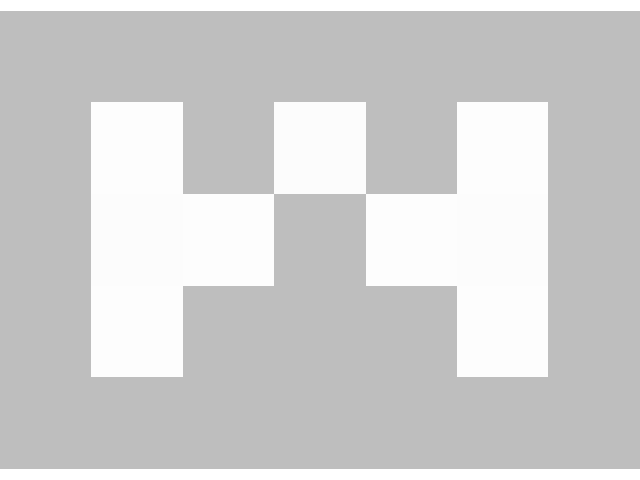

In [73]:
%matplotlib notebook

f1 = plt.figure("GOOD1")
ax = f1.add_subplot(111)

p_pattern, _ = poison_pattern(torch.zeros((1, 4, 32, 32)), torch.zeros_like(target), 8, 1.1)
ax.imshow(th(p_pattern[0,:,1:8,22:27]).T)

ax.axis('off')
ax.set_position([0, 0, 1, 1])
# ax.plot(x, y, 'b', alpha=(0.015625))
# ax.set_xlim((x.min(), x.max()))
# ax.set_ylim((y.min(), y.max()))
f1.patch.set_alpha(0.)
ax.patch.set_alpha(0.)
f1.savefig("backdoor.svg", bbox_inches=0, transparent=True)
# f1.savefig("GOOD1.png", bbox_inches=0, transparent=True)

In [ ]:
p_pattern[0].max()

 normally poisoned model:

<IPython.core.display.Javascript object>


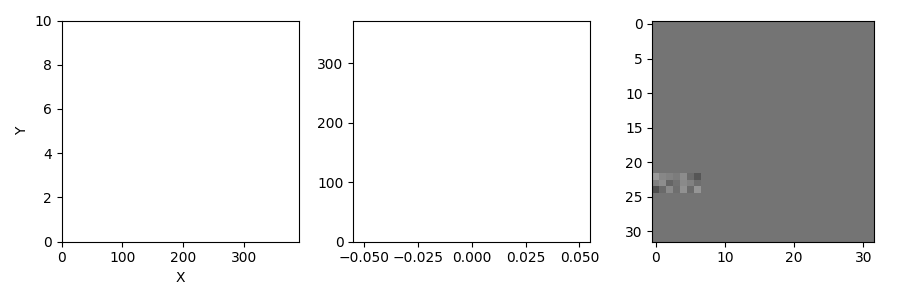

finished


In [27]:
normally_poisoned = train_nc('Sep.11_14.56.21')

<IPython.core.display.Javascript object>


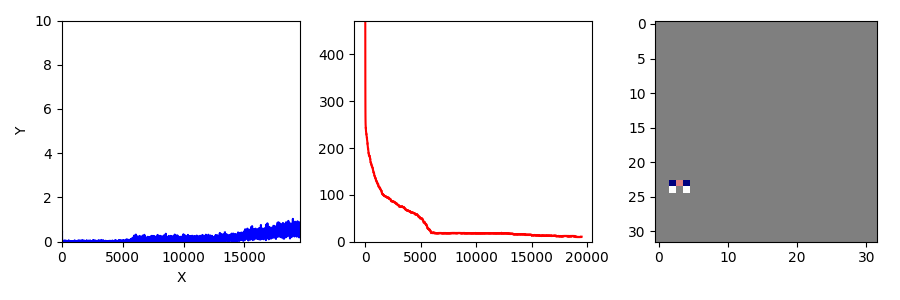

In [47]:
#normal two-pixel
tp_normal = train_nc('cifar_Oct.01_11.37.45')

In [ ]:
th(normally_poisoned.mask)[0,2:9,22:27]

This is no poison model:

<IPython.core.display.Javascript object>


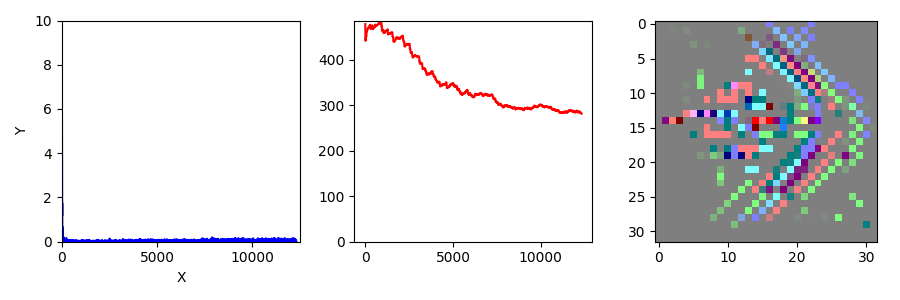

finished


In [49]:
no_poisoned = train_nc('Aug.15_11.40.44')

Poisoned with adversarial loss:

In [ ]:
try:
    train('Sep.14_16.52.47')
except KeyboardInterrupt:
    print('finished')

semantic attack

In [ ]:
try:
    train('Sep.11_12.56.37')
except KeyboardInterrupt:
    print('finished')

fixed

In [ ]:
fixed_poisoned = train_nc('Sep.17_18.05.23')


In [ ]:
latent_trained = train_nc('Sep.17_17.32.35')


In [ ]:
th(latent_trained.mask).sum()

long trained

In [ ]:
long_trained = train_nc('Sep.15_00.27.23')



latent

In [ ]:
long_trained2 = train_nc('Sep.16_13.58.31')

single pixel

In [10]:
# sp = train_nc('Sep.18_23.46.10')

<IPython.core.display.Javascript object>


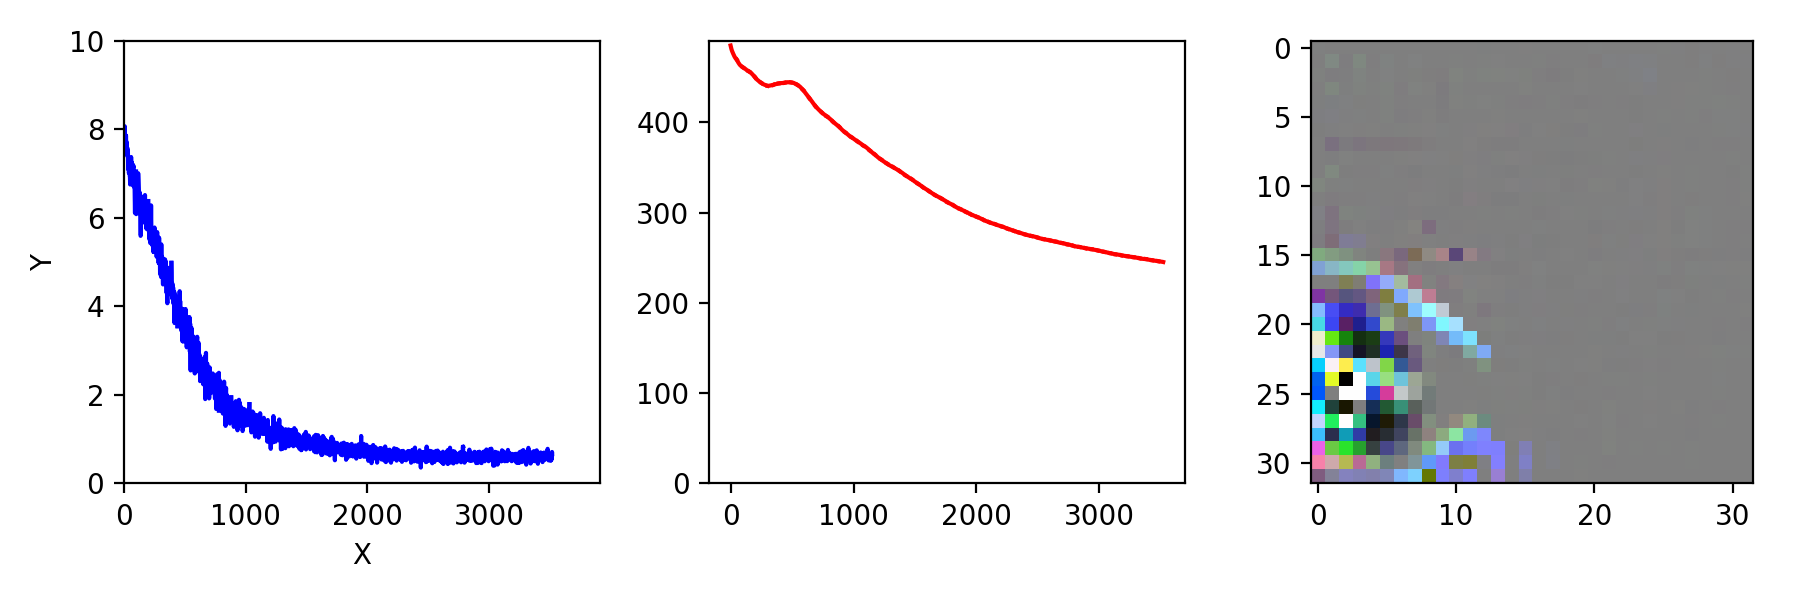

finished


In [16]:
sp = train_nc('cifar_Sep.30_18.13.45')

<IPython.core.display.Javascript object>


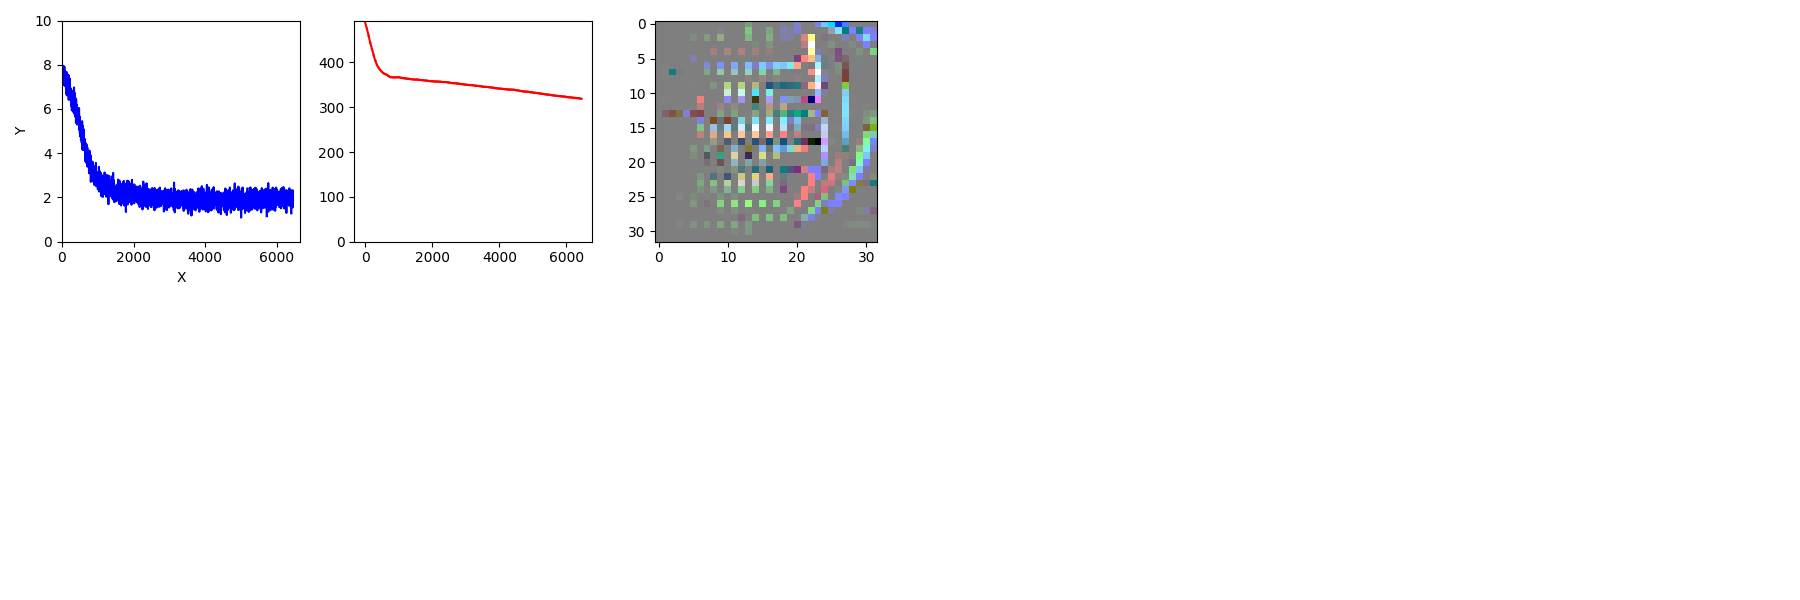

In [ ]:
# two pixels

tp = train_nc('cifar_Sep.30_20.42.48')

<IPython.core.display.Javascript object>


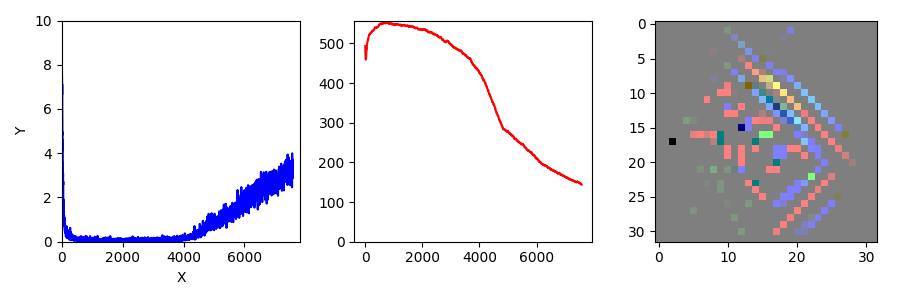

finished


In [48]:
# two pixels l2
tpl2 = train_nc('cifar_Oct.01_01.18.48')

In [15]:
certified_model = load_model('/home/eugene/bd_proj/smoothing/models/cifar10/resnet110/noise_0.12/checkpoint.pth.tar', smooth=True).to('cpu')
certified_model = certified_model.to('cuda')

### noised with sigma=1.00

<IPython.core.display.Javascript object>


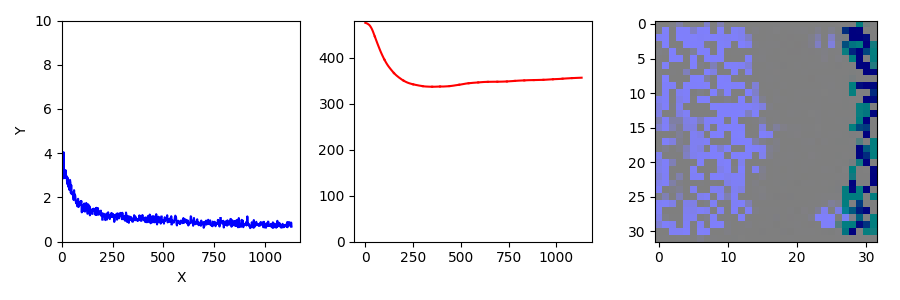

finished


Mixed(
  (resnet): Sequential(
    (0): NormalizeLayer()
    (1): SResNet(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [11]:
cert1 = train_nc(certified_model, smooth=True)

<IPython.core.display.Javascript object>


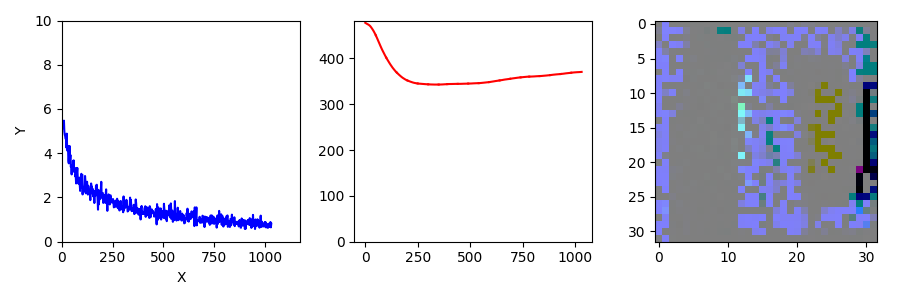

finished


In [14]:
cert_05 = train_nc(certified_model, smooth=True)

### Noised with sigma=0.25

<IPython.core.display.Javascript object>


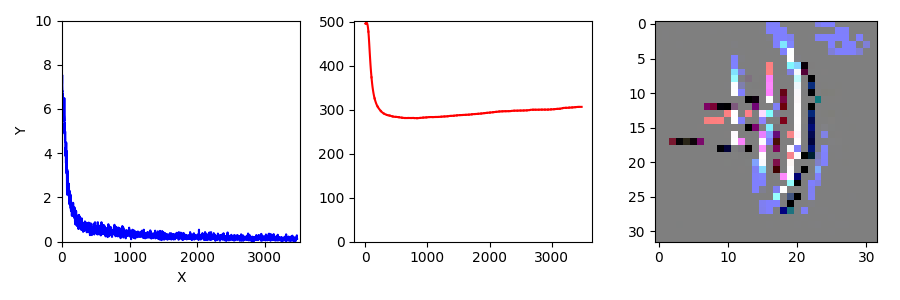

finished


In [17]:
cert = train_nc(certified_model, smooth=True)

<IPython.core.display.Javascript object>


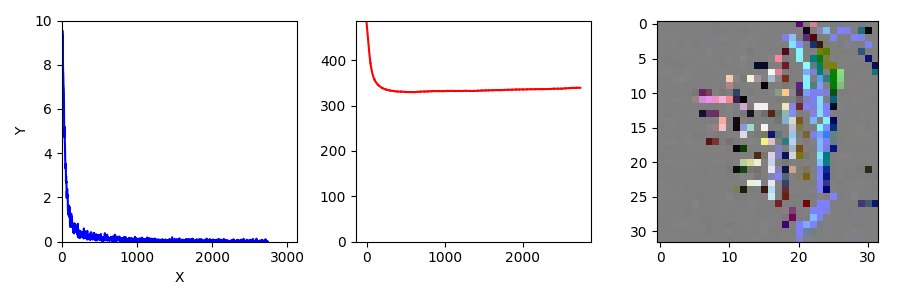

finished


In [16]:
cert_12 = train_nc(certified_model, smooth=True)

In [1]:
#normal two-pixel
tp_normal = train_nc('imagenet_Feb.13_15.04.04')

NameError: name 'train_nc' is not defined

In [ ]:
latent_model = load_model('Sep.17_17.32.35').to('cpu')

In [ ]:
latent_model = load_model('Sep.15_00.26.53')

In [35]:
for (batch, target) in helper.test_loader:
#     batch = batch.to('cpu')
#     target = target.to(helper.device)
    batch_poison, target_poison = poison_pattern(batch,target, 8, 1.1)
    
    break

In [ ]:
target.shape

In [36]:
batch_poison, target_poison = poison_pattern(batch,target, 8, 1.1)

In [ ]:
latent = torch.zeros((100*100, 512)).to('cuda')
latent_back = torch.zeros((100*100, 512)).to('cuda')

In [40]:
torch.max(tp_normal(batch)[0], 1)

torch.return_types.max(
values=tensor([12.7163, 14.4570,  9.2364,  8.0866,  9.6338, 11.0325,  9.4892,  9.5152,
        12.2302,  8.9882, 10.6367, 13.7322,  5.0991, 10.1607, 12.0954,  8.3230,
        11.0091,  7.8987, 12.4207,  9.2421,  6.1870, 11.0574,  9.7174, 11.8501,
        12.4830,  8.7636,  8.1470, 12.4955, 11.4864, 11.4006,  6.8082, 11.6726,
        11.0433,  5.2507, 13.5545,  6.2161, 11.9485,  6.7776, 13.3851, 11.1976,
         8.9619,  8.4707,  7.1471,  9.8280, 11.7611, 12.6923,  7.3519,  5.8056,
        11.5355,  6.0780,  8.5654, 11.3779,  7.0221,  8.1691, 12.8022, 10.1708,
         9.2799,  9.9113,  4.5391,  7.0487,  9.7149,  9.8854, 13.5514,  6.6762,
         9.5062, 14.3328, 10.3656, 12.7318,  5.9717,  7.8992,  3.5762, 10.5161,
         9.6082, 12.2303,  8.4299, 15.5070,  9.3916, 12.7640,  6.8856, 11.6334,
        11.7507, 10.6778, 11.0485,  9.5200,  7.8130,  8.3449,  5.6891,  4.1488,
        11.7777, 12.2368, 11.9557,  8.0989, 12.7556, 11.4887,  8.8635,  6.8851,
         

In [ ]:
latent_model.eval()
torch.max(latent_model(batch_poison)[0], 1)

In [ ]:
f'saved_models/model_image_Sep.17_17.32.35/model_last.pt.tar'

In [ ]:
target_poison

In [35]:
model = torch.load('/home/eugene/bd_proj/smoothing/models/cifar10/resnet110/noise_0.25/checkpoint.pth.tar')

In [22]:
from models.smoothnet import *
from models.resnet import NormalizeLayer

In [36]:
_CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
_CIFAR10_STDDEV = [0.2023, 0.1994, 0.2010]

smodel = sresnet(depth=110, num_classes=10)
normalize_layer = NormalizeLayer(_CIFAR10_MEAN, _CIFAR10_STDDEV)
smodel = torch.nn.Sequential(normalize_layer, smodel)

In [37]:
model['arch']

'cifar_resnet110'

In [38]:
smodel.load_state_dict(model['state_dict'])

<All keys matched successfully>

In [39]:
smodel = smodel.to('cuda')

In [57]:
test(helper, certified_model.to('cuda'), criterion, epoch=0, is_poison=True)

100%|██████████| 100/100 [00:02<00:00, 36.41it/s]
Epoch 0. Poisoned: True. Accuracy: 70.64%


(70.64, 93.15162754058838)

In [ ]:
helper.data = 'cifar'

In [ ]:
( th(mixed.mask.cpu().detach())*th(mixed.pattern.cpu().detach()) ).squeeze().shape

In [ ]:
%matplotlib notebook


((maskh*patternh).max(), (maskh*patternh).min())
plt.imshow((th(mixed.mask.cpu().detach())*th(mixed.pattern.cpu().detach())), vmin=0, vmax=1)


In [ ]:
wr = SummaryWriter(log_dir=f'runs/nc')
helper.writer = wr

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
# %matplotlib notebook

# fig,ax = plt.subplots(1,1)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')

# ax.set_ylim(0,10)

x_l = []
y_l_n = []
y_l = []

tasks = ['c','n']

for j in range(50):
#     test(helper, mixed.resnet, criterion, epoch=j, is_poison=False)
#     test(helper, mixed.resnet, criterion, epoch=j, is_poison=True)
    ax.set_xlim(0,391*(j+1))
    for z, (batch, target) in enumerate(helper.train_loader):
    #     mask.requires_grad_(True)
        mixed.zero_grad()
        for i, n in mixed.named_parameters():
            if i!='mask' and i!='pattern':
                n.requires_grad_(False)
            else:
                n.requires_grad_(True)
        batch = batch.to(helper.device)
        target = target.to(helper.device)
        poison_batch, poison_target = poison_pattern(batch, target, 8, 1.0)
#         target.fill_(8)
        grads = {}
        loss_data = {}
        
        pred = mixed(batch)
        loss_class = criterion(pred, poison_target) 
        loss_class.backward()
        grads['c'] = helper.copy_grad(mixed)
        loss_data['c'] = loss_class
        
        mixed.zero_grad()

        loss_n = torch.sum(th(mixed.mask))
        loss_n.backward()
        grads['n'] = helper.copy_grad(mixed)
        loss_data['n'] = loss_n
        
        scale = MinNormSolver.get_scales(grads, loss_data, 'none', tasks, None, helper.log_interval)

        mixed.zero_grad()
        pred = mixed(batch)
        
        loss_n = torch.sum(th(mixed.mask))
        loss_class = criterion(pred, poison_target)
#         print(scale)
#         loss = 0.01* loss_n + 0.9 * loss_class
        loss = scale['n'] * loss_n + scale['c'] * loss_class
    
#         loss = (1-cost)*loss_class + cost*loss_n
#         c = (j + i/391)/30

        loss.backward()
        optimizer.step()
        mixed.zero_grad()        
        
        
        for i, n in mixed.named_parameters():
            if i=='mask' or i=='pattern':
                n.requires_grad_(False)
            else:
                n.requires_grad_(True)
        mixed.zero_grad()        
        
        pred_poison, _ = mixed.resnet(poison_batch)
        pred_normal, _ = mixed.resnet(batch)
        
        pred_nc = mixed(batch)
        
        loss_nc = criterion(pred_nc, poison_target)
        
        loss_poison = criterion(pred_poison, poison_target)
        loss_normal = criterion(pred_normal, target)
        
        loss =  loss_poison + loss_normal - loss_nc
        
        loss.backward()
        optimizer_back.step()
        
        helper.plot(391*j + z , loss_nc.item(), 'exps/nc')
        helper.plot(391*j + z , loss_poison.item(), 'exps/loss_poison')
        helper.plot(391*j + z , loss_normal.item(), 'exps/loss_normal')
        
        
        
        
        
        
        
        
        
#         if z%2 == 0:
#             x_l.append(391*j + z)
#             y_l.append(loss_class.item())
#             y_l_n.append(loss_n.item())
#         if z%10 == 0:
#             ax.plot(x_l, y_l, 'b')
#             ax.plot(x_l, y_l_n, 'r')
            
#             ax.set_ylim(0,10)
#             fig.canvas.draw()
#             x_l = x_l[-1:]
#             y_l = y_l[-1:]
#             y_l_n = y_l_n[-1:]
            

#### experiments

In [ ]:
mixed.mask.T.shape

In [ ]:
maskh.max()

In [ ]:
def th(vector):
    return torch.tanh(vector)/(2-1e-5)+0.5

In [ ]:
poison_batch, poison_target = poison_pattern(batch, target, 8, 1.1)

In [ ]:
(maskh*patternh).shape

In [ ]:
batch[0].T.shape

In [ ]:
%matplotlib notebook
plt.imshow(poison_batch[1].T.cpu().detach())
# plt.imshow(maskh*patternh + (1-maskh)*batch[1].T.cpu().detach())

In [ ]:
%matplotlib notebook
f, (ax1, ax2, ax3) = plt.subplots(
            1, 3
        )

maskh = (th(mixed.mask).repeat([3,1,1])).T.cpu().detach()#[23:26, 2:7]
patternh = (th(mixed.pattern).repeat([3,1,1])).T.cpu().detach()#[23:26, 2:7]

ax1.imshow(maskh*patternh + (1-maskh)*batch[2].T.cpu().detach())
# ax2.imshow(poison_batch[2].T.cpu().detach())
ax2.imshow(maskh*patternh)
ax3.imshow(patternh)
plt.show()

## semantic backdoor

In [ ]:
%matplotlib notebook
f, (ax1, ax2, ax3) = plt.subplots(
            1, 3
        )

maskh = (torch.tanh(mixed.mask)/2+0.5).cpu().detach()#[2:7,23:26]
patternh = torch.tanh(mixed.pattern).cpu().detach()#[2:7,23:26]

ax1.imshow(maskh*patternh+0.5)
ax2.imshow(maskh)
ax3.imshow(patternh)
plt.show()

## no backdoor

In [ ]:
%matplotlib notebook
f, (ax1, ax2, ax3) = plt.subplots(
            1, 3
        )

maskh = (torch.tanh(mixed.mask)/2+0.5).cpu().detach()#[2:7,23:26]
patternh = torch.tanh(mixed.pattern).cpu().detach()#[2:7,23:26]

ax1.imshow(maskh*patternh+0.5)
ax2.imshow(maskh)
ax3.imshow(patternh)
plt.show()

## with backdoor:

In [ ]:
%matplotlib notebook
f, (ax1, ax2, ax3) = plt.subplots(
            1, 3
        )

maskh = (torch.tanh(mixed.mask)/2+0.5).cpu().detach()#[2:7,23:26]
patternh = torch.tanh(mixed.pattern).cpu().detach()#[2:7,23:26]

ax1.imshow(maskh*patternh+0.5)
ax2.imshow(maskh)
ax3.imshow(patternh)
plt.show()

In [ ]:
pilimage((torch.tanh(mixed.mask)*mixed.pattern).cpu())

In [ ]:
torch.tanh(mixed.mask).min()

In [ ]:
batch.min()

In [ ]:
pilimage((mixed.pattern).cpu())

In [ ]:
pilimage((mixed.mask).cpu())

In [ ]:
torch.norm(mixed.mask)

In [ ]:
torch.max(mixed(batch), 1)[1]

In [ ]:
(torch.max(mixed(batch.to('cuda')), 1)[1] == 8 ).sum()

In [ ]:
(torch.max(bck_model(poison_batch.to('cuda')), 1)[1] == 8).sum()

In [ ]:
batch = batch.to(helper.device)
bck_model = bck_model.to(helper.device)
(torch.max(bck_model(batch), 1)[1] == 8).sum(), (target==8).sum()

In [ ]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

def pltsin(ax, colors=['b']):
    x = np.linspace(0,1,100)
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            y = np.random.random(size=(100,1))
            line.set_ydata(y)
    else:
        for color in colors:
            y = np.random.random(size=(100,1))
            ax.plot(x, y, color)
    fig.canvas.draw()

fig,ax = plt.subplots(1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
for f in range(5):
    pltsin(ax, ['b', 'r'])
    time.sleep(1)

In [ ]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

In [ ]:
b.backward()

In [ ]:
b.grad

In [ ]:
a.grad

In [ ]:
%matplotlib notebook

plt.imshow(torch.normal(0.5, 0.1, [32,32,3]).type(torch.float))

In [ ]:
batch.device

In [ ]:
n = mixed.norm()

In [ ]:
n.backward()

In [ ]:
pattern.grad

In [ ]:
writer.add_graph(mixed, batch)

In [ ]:
images, labels = next(iter(helper.test_loader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(mixed.to('cpu'), images)
writer.flush()  

In [ ]:
loss

In [17]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.pyplot as plt
from data.multi_mnist_loader import MNIST


def global_transformer():
    return transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))])


dst = MNIST(root='./data', train=True, download=True, transform=global_transformer(), multi=True)
loader = torch.utils.data.DataLoader(dst, batch_size=10, shuffle=True, num_workers=4)
for dat in loader:
    ims = dat[0].view(10, 28, 28).numpy()

    labs_l = dat[1]
    labs_r = dat[2]
    f, axarr = plt.subplots(2, 5)
    for j in range(5):
        for i in range(2):
            axarr[i][j].imshow(ims[j * 2 + i, :, :], cmap='gray')
            axarr[i][j].set_title('{}_{}'.format(labs_l[j * 2 + i], labs_r[j * 2 + i]))
    plt.show()
    a = input()
    if a == 'ex':
        break
    else:
        plt.close()


Processing...


KeyboardInterrupt: 

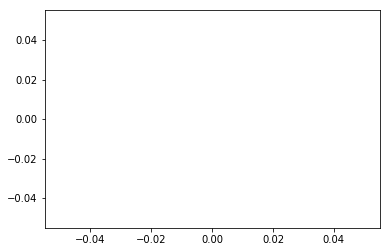

In [19]:
%matplotlib inline

plt.plot(x=[1, 2, 3,4 , 5, 23], y=[1, 2, 3,4 , 5, 23])
plt.show()

# IMAGENET

In [11]:
from models.original_resnet import *


with open('utils/params_imagenet.yaml', 'r') as f:
    params = yaml.load(f)
params['tb'] = False
params['log'] = False
params['save_model'] = False
d = datetime.now().strftime('%b.%d_%H.%M.%S')
helper = ImageHelper(current_time=d, params=params, name='image')

helper.load_imagenet()


helper.device = 'cuda'

def load_model_imagenet(path=None):
    model = resnet18(pretrained=True)
    if path:
        dicts = torch.load(f'saved_models/model_image_{path}/model_last.pt.tar')
        print(dicts['epoch'])
        model.load_state_dict(dicts['state_dict'])    
#         model = torch.nn.Sequential(NormalizeLayer(), model)
#     model.load_state_dict(dicts['state_dict'])     
    model = model.to(helper.device)
#     model.eval()
    return model


criterion = torch.nn.CrossEntropyLoss()

/home/eugene/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


In [108]:
%matplotlib notebook

def train_nc_imagenet(name=None, smooth=False, label=8):
    reseed(5)
    mixed = Mixed(load_model_imagenet(name), size=224)
#     mixed.init_pattern()
    # mixed = Mixed('Aug.31_15.23.24')
    # 'Sep.14_15.02.38'
    # mixed = Mixed(load_model('Sep.14_15.02.38'))
    for i, n in mixed.named_parameters():
        if i!='mask' and i!='pattern':
            n.requires_grad_(False)
        else:
            n.requires_grad_(True)
    criterion = nn.CrossEntropyLoss().to(helper.device)
    mixed = mixed.to(helper.device)
    mixed.eval()
    optimizer = torch.optim.Adam(mixed.parameters(), lr=0.01)


    fig,(ax, ax2, ax3) = plt.subplots(1,3,figsize=(9,3))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    ax.set_ylim(0,100)
    # ax2 = ax1.twinx() 
    # ax2.tick_params(axis='y', labelcolor='b')
    max_y=10
    x_l = []
    y_l_n = []
    y_l = []
    y_scale_n = []
    y_scale_c = []
    running_scale = dict()
    tasks = ['c','n']
    try:
        for j in range(50):
            ax.set_xlim(0,391*(j+1))
            for i, (batch, target) in enumerate(helper.train_loader):
#                 if i>100:
#                     break
            #     mask.requires_grad_(True)
                mixed.zero_grad()
                batch = batch.to(helper.device)
            #     batch_new = (mask-1)*batch + mask*pattern
                target.fill_(label)
                grads = {}
                loss_data = {}

#                 pred, _ = mixed(batch.to(helper.device))
#                 loss_class = criterion(pred, target.to(helper.device)) 
#                 loss_class.backward()
#                 grads['c'] = helper.copy_grad(mixed)
#                 loss_data['c'] = loss_class

#                 mixed.zero_grad()

#                 loss_n = torch.sum(th(mixed.mask))
#                 loss_n.backward()
#                 grads['n'] = helper.copy_grad(mixed)
#                 loss_data['n'] = loss_n

#                 scale = MinNormSolver.get_scales(grads, loss_data, 'loss+', tasks, running_scale, helper.log_interval)
                scale = {'n': 0.001, 'c': 0.999}
                mixed.zero_grad()
                pred, _ = mixed(batch.to(helper.device))
                missclassified = 100*(pred.argmax(dim=1)==label).sum().item()/helper.batch_size

                loss_n = torch.sum(th(mixed.mask))
                loss_class = criterion(pred, target.to(helper.device))
        #         print(scale)
#                 loss = 0.01* loss_n + 0.99 * loss_class
                loss = scale['n'] * loss_n + scale['c'] * loss_class

        #         loss = (1-cost)*loss_class + cost*loss_n
        #         c = (j + i/391)/30
                loss.backward()
                optimizer.step()
                if i%2 == 0:
                    x_l.append(391*j + i)
                    y_l.append(missclassified)
                    y_l_n.append(loss_n.item())
                    y_scale_n.append( scale['n'])
                    y_scale_c.append(scale['c'])
                    
                if i%10 == 0:
#                     print(x_l[-1], y_l[-1], y_l_n[-1])
                    ax.plot(x_l, y_l, 'b')
                    ax2.plot(x_l, y_l_n, 'r')
                    max_y = max(max_y, max( y_l_n)+5)
                    ax2.set_ylim(0, max_y + 0.1*max_y)
# .repeat([3,1,1])
                    maskh = (th(mixed.mask)).cpu().detach()
                    grey = torch.zeros_like(maskh).fill_(0.5)
                    patternh = unnorm(thp(mixed.pattern).cpu().detach())
                    p = maskh*patternh + (1-maskh)*grey
                    ax3.imshow(pilimage(p),  cmap='gray') # vmin=0, vmax=1,
#                     ax4.plot(x_l, y_scale_n)
#                     ax4.set_title('sum')
#                     ax5.plot(x_l, y_scale_c)
#                     ax5.set_title('class')

                    fig.tight_layout() 
                    fig.canvas.draw()
                    x_l = x_l[-1:]
                    y_l = y_l[-1:]
                    y_l_n = y_l_n[-1:]
                    y_scale_n = y_scale_n[-1:]
                    y_scale_c = y_scale_c[-1:]
    except KeyboardInterrupt:
        print('finished', np.mean(y_l_n), np.mean(y_l))
        plt.savefig(f'./imagenet_{name}.png', format='png')
        mixed = mixed.to('cpu')
        return mixed
            

loss - doesn't work too much emphasis on sum

none - no sum

l2 - values are too small

loss+ - still unbalanced

<IPython.core.display.Javascript object>


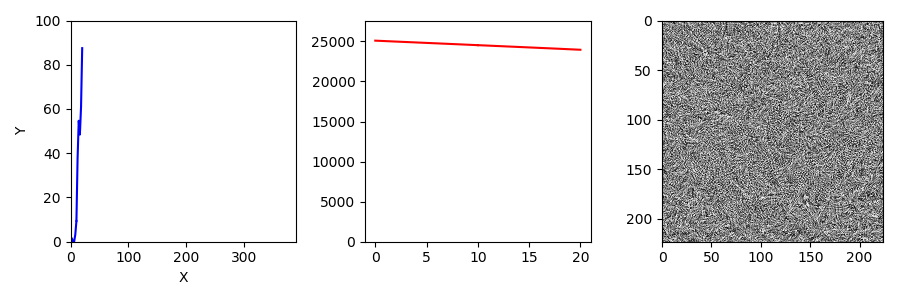

finished 23754.0830078125 89.0625


In [32]:
model = train_nc_imagenet()

In [30]:
p.min()

tensor(0.2133)

<IPython.core.display.Javascript object>


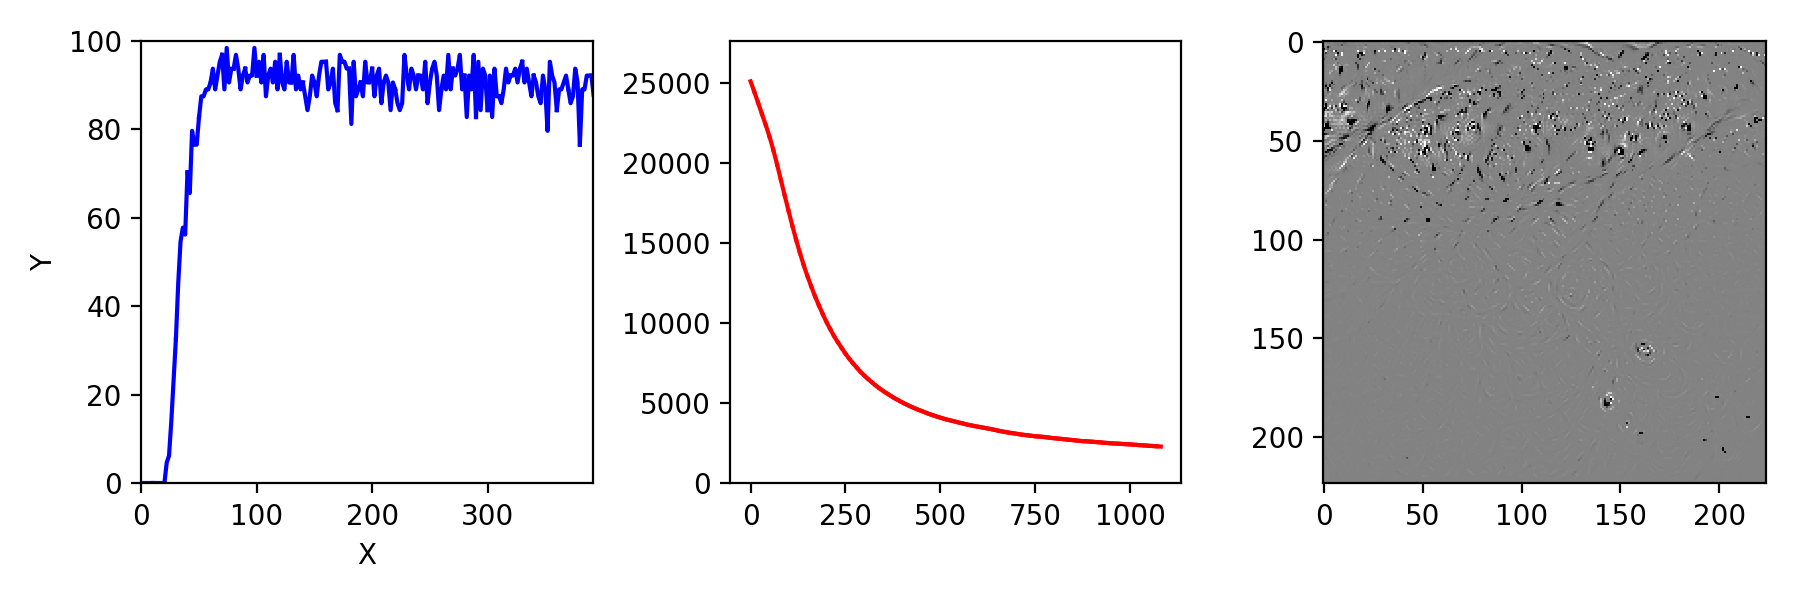

finished 2299.6611328125 89.84375


In [111]:
model = train_nc_imagenet(label=954)

<IPython.core.display.Javascript object>


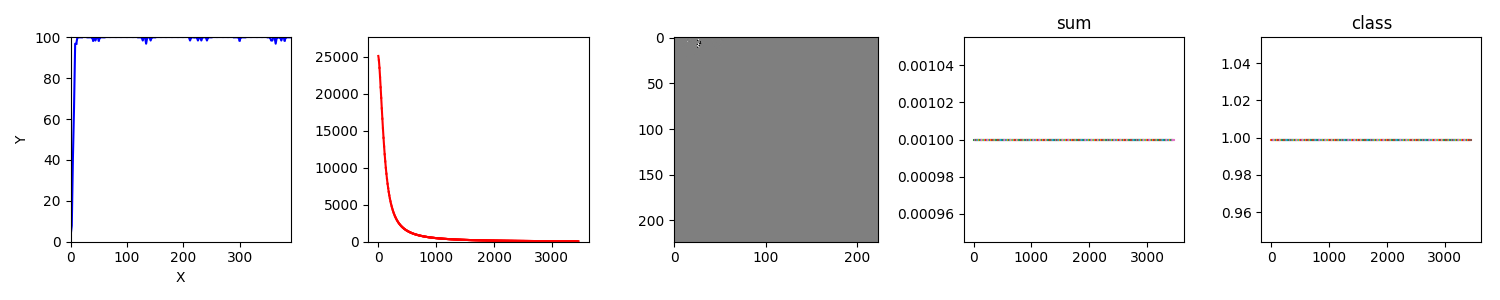

finished 58.91486167907715 99.21875


In [366]:
model = train_nc_imagenet('imagenet_Feb.13_12.08.33')

<IPython.core.display.Javascript object>


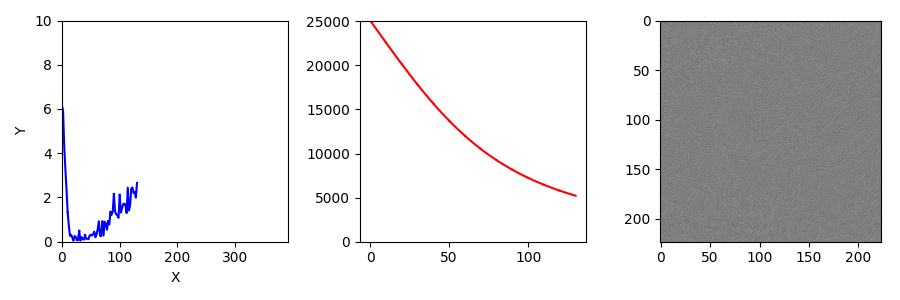

finished 5117.361165364583 2.671039263407389


In [314]:
model = train_nc_imagenet('imagenet_Feb.13_12.08.33')

<IPython.core.display.Javascript object>


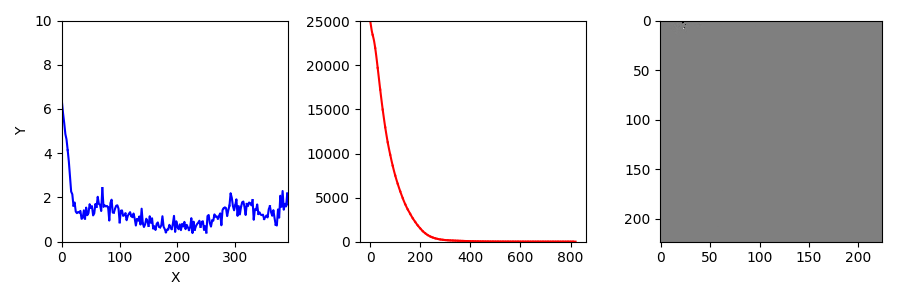

finished 11.0252685546875 6.143014907836914


In [278]:
model = train_nc_imagenet('imagenet_Feb.15_14.33.08')

<IPython.core.display.Javascript object>


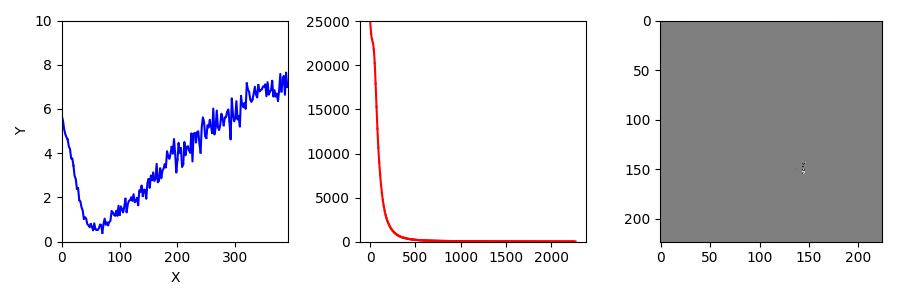

finished 19.36708927154541 9.70986032485962


In [280]:
model = train_nc_imagenet('imagenet_Feb.21_23.20.57')

203


<IPython.core.display.Javascript object>


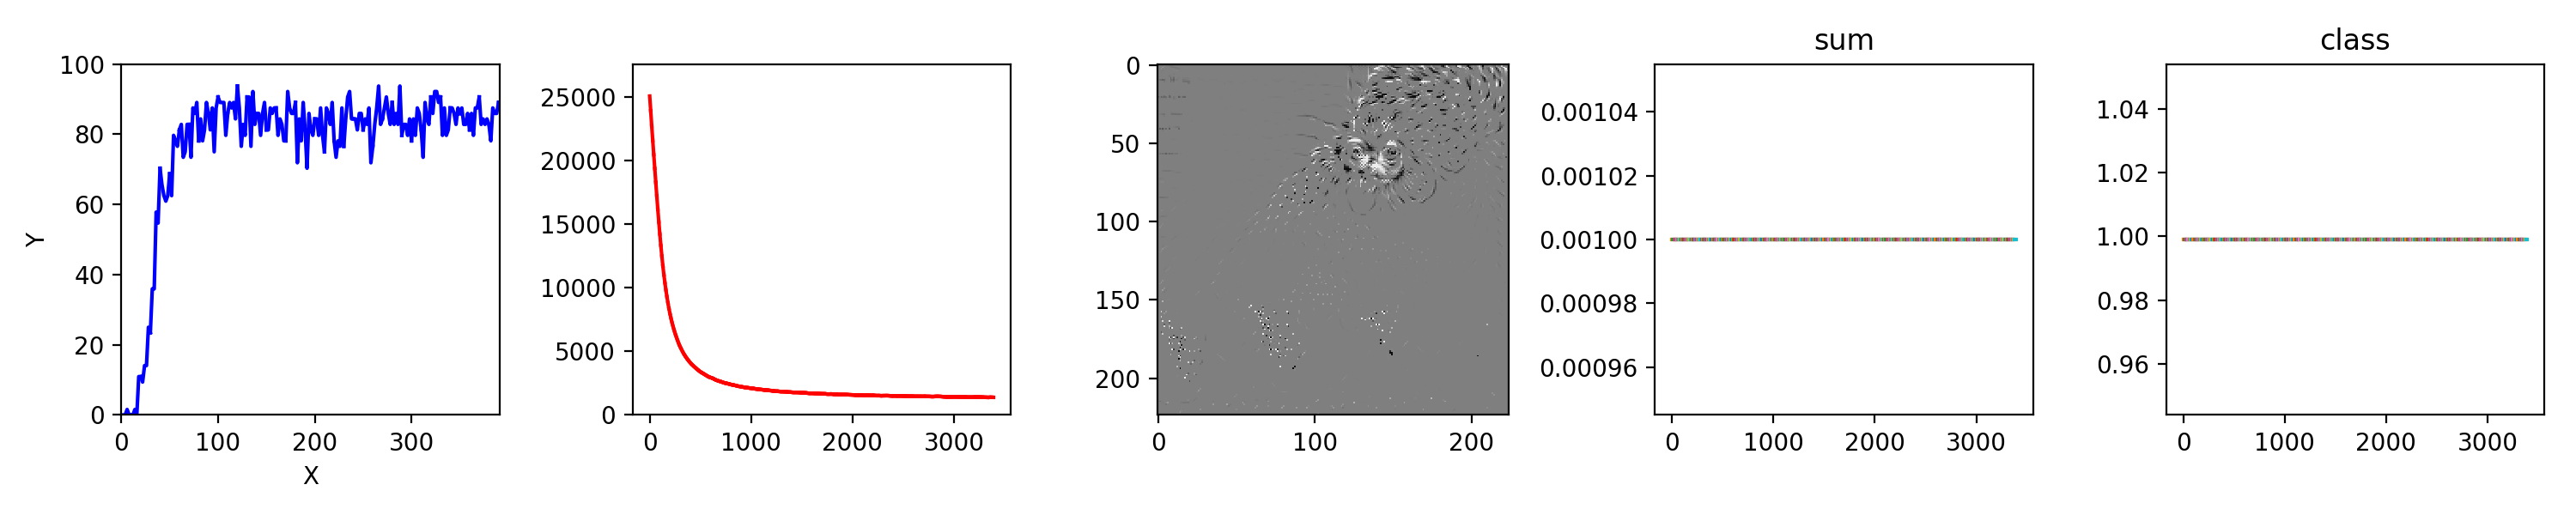

finished 1383.7971435546874 90.9375


In [370]:
model = train_nc_imagenet('imagenet_Feb.21_23.20.57')

34


<IPython.core.display.Javascript object>


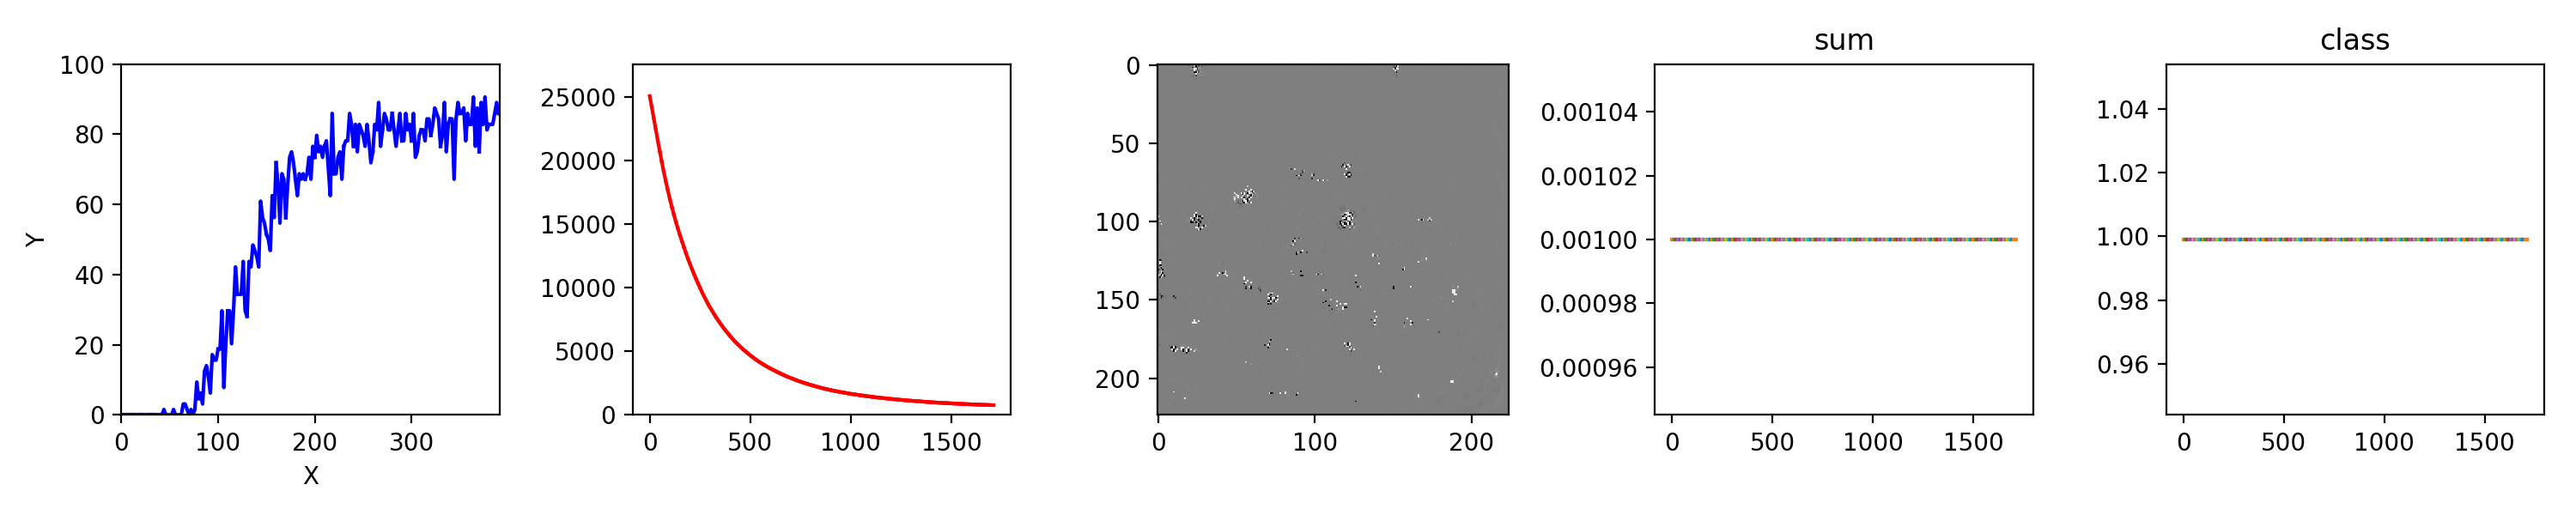

finished 767.6740966796875 94.375


In [368]:
model = train_nc_imagenet('imagenet_Feb.22_11.26.48')

31


<IPython.core.display.Javascript object>


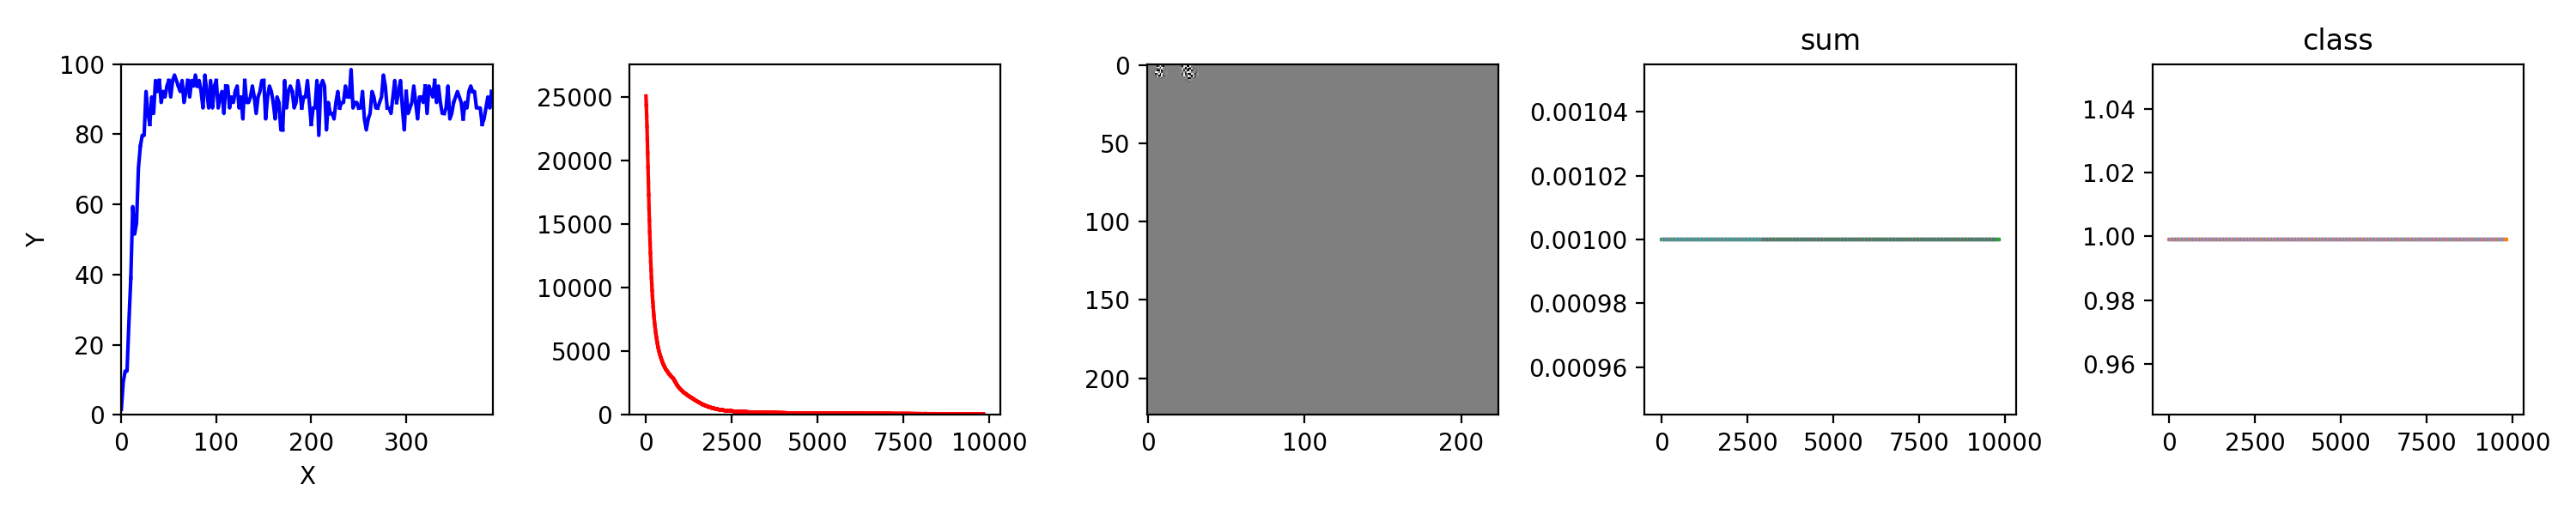

finished 84.81266657511394 99.73958333333333


In [372]:
model = train_nc_imagenet('imagenet_Feb.22_13.48.45')

3


<IPython.core.display.Javascript object>


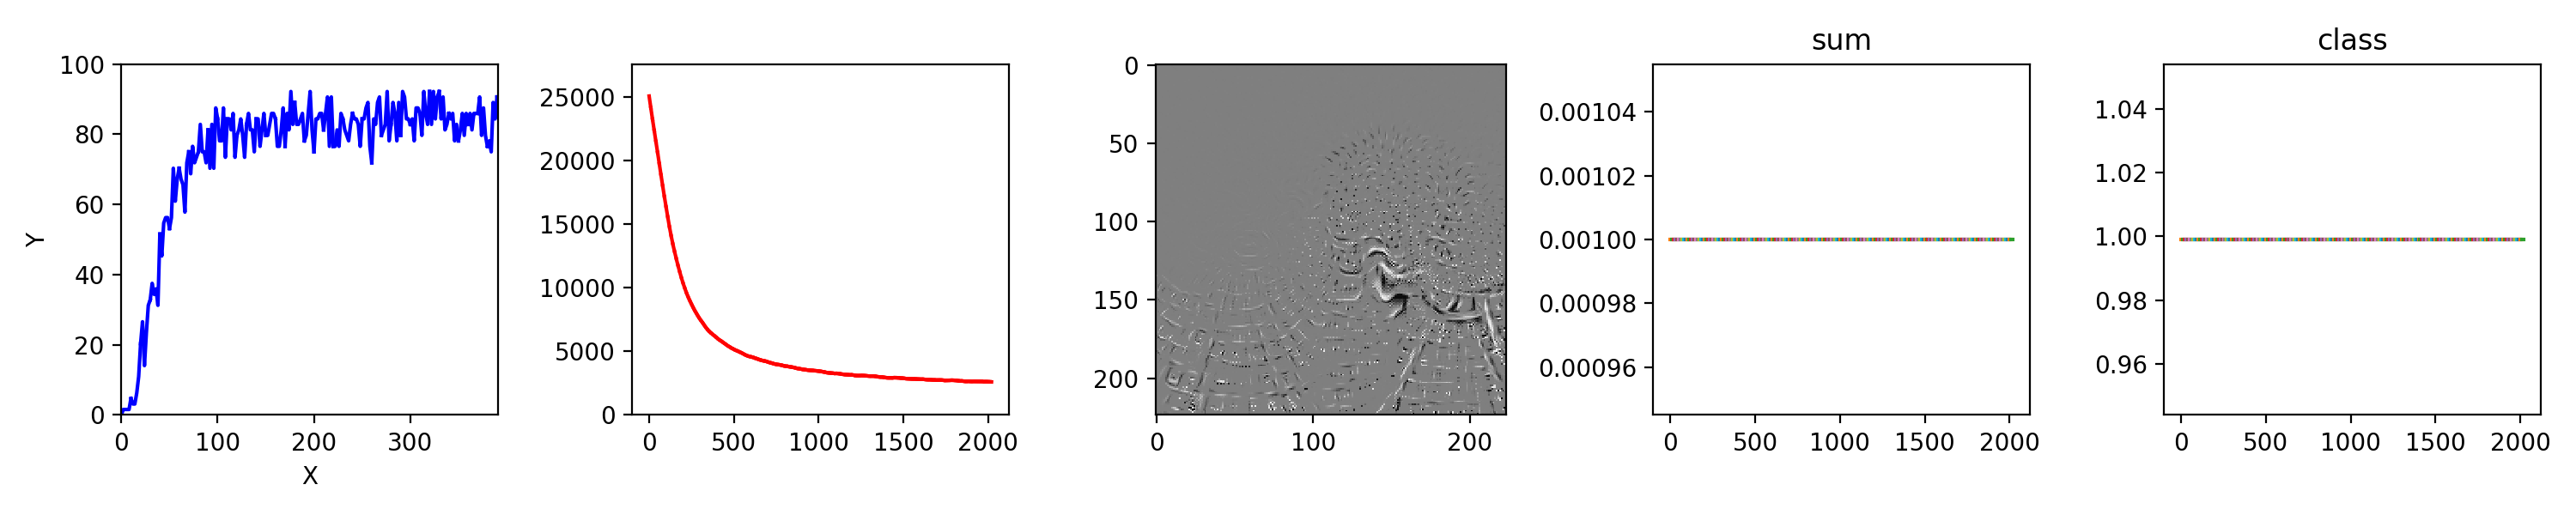

finished 2597.0203857421875 89.453125


In [6]:
model = train_nc_imagenet('imagenet_Feb.22_15.08.46')

3


<IPython.core.display.Javascript object>


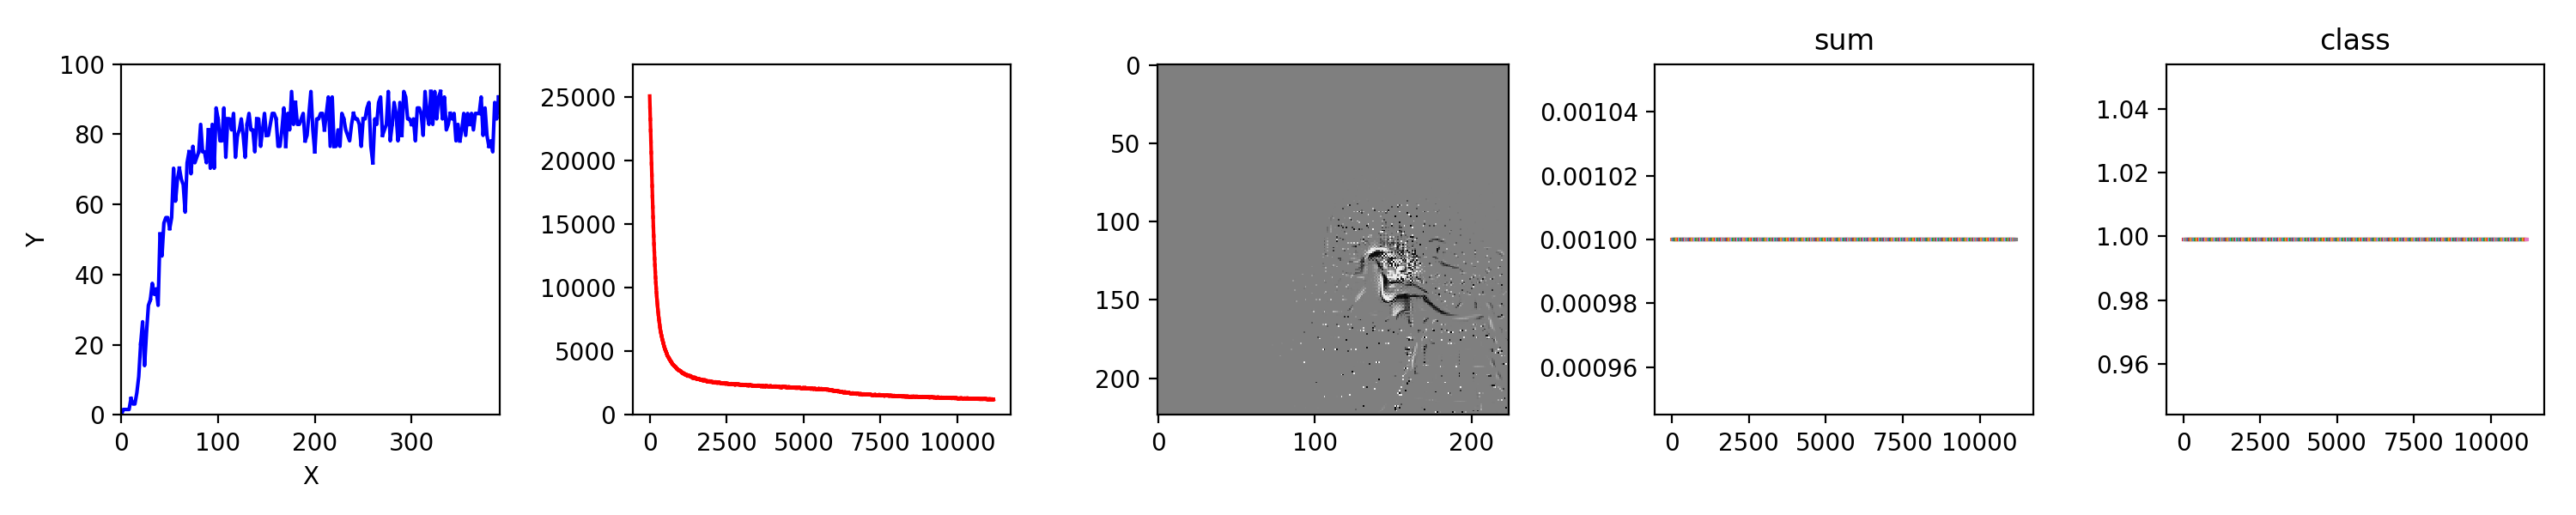

finished 1222.9392578125 95.9375


In [8]:
model = train_nc_imagenet('imagenet_Feb.22_15.08.46')

2


<IPython.core.display.Javascript object>


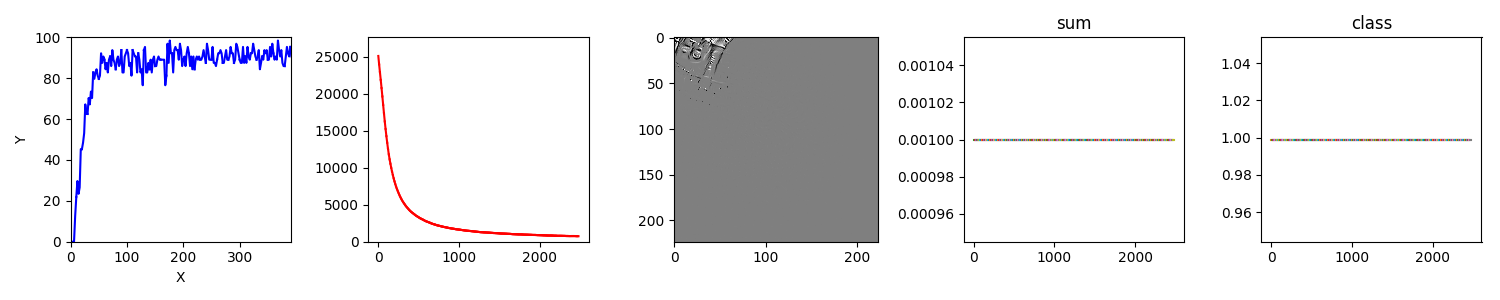

In [ ]:
model = train_nc_imagenet('imagenet_Feb.22_16.31.54')

In [24]:
maskh = (th(model.mask)).cpu().detach()
patternh = thp(model.pattern).cpu().detach()
p = maskh*unnorm(patternh) #+ torch.ones_like(patternh)*(1-maskh)
plt.imshow(pilimage(p))

5


<IPython.core.display.Javascript object>


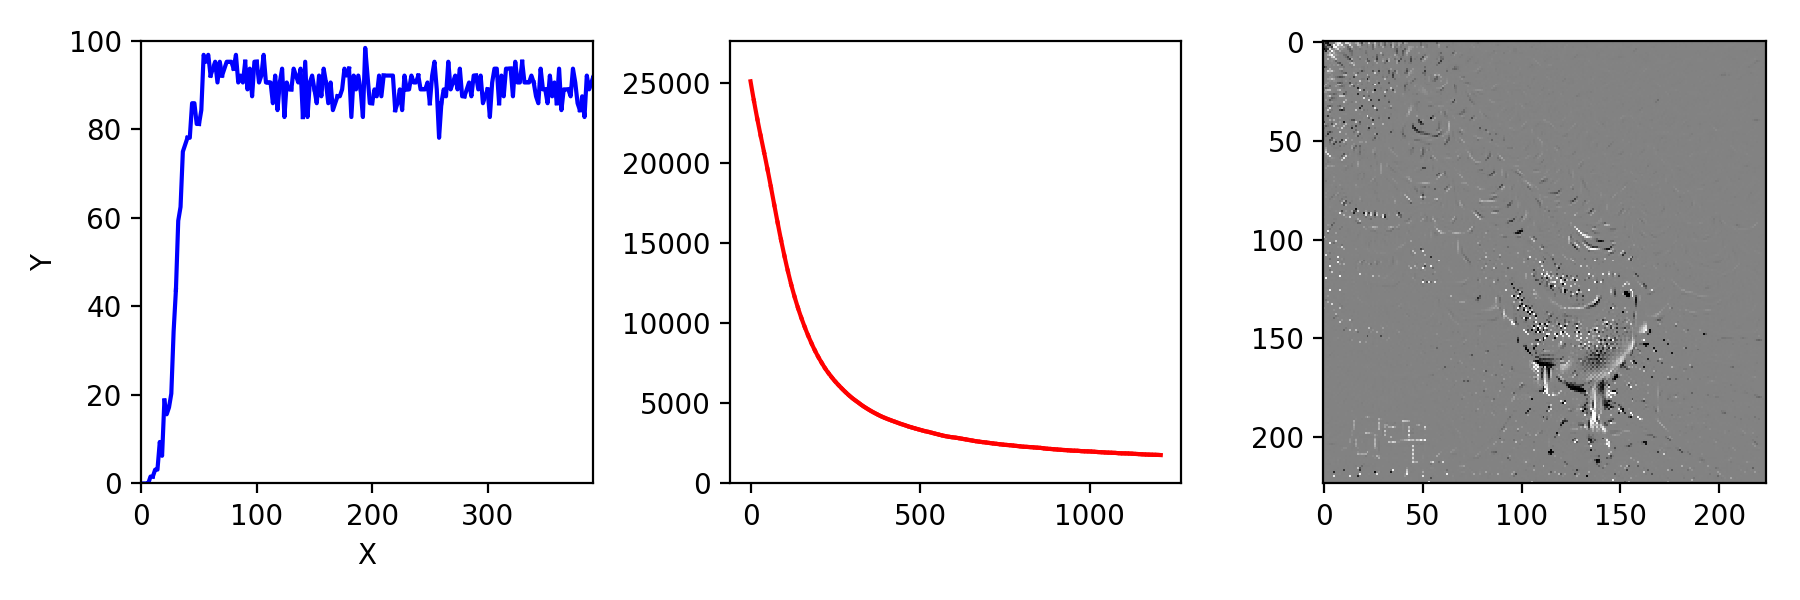

finished 1776.5318806966145 94.27083333333333


In [38]:
model = train_nc_imagenet('imagenet_Aug.01_17.44.21')

1


<IPython.core.display.Javascript object>


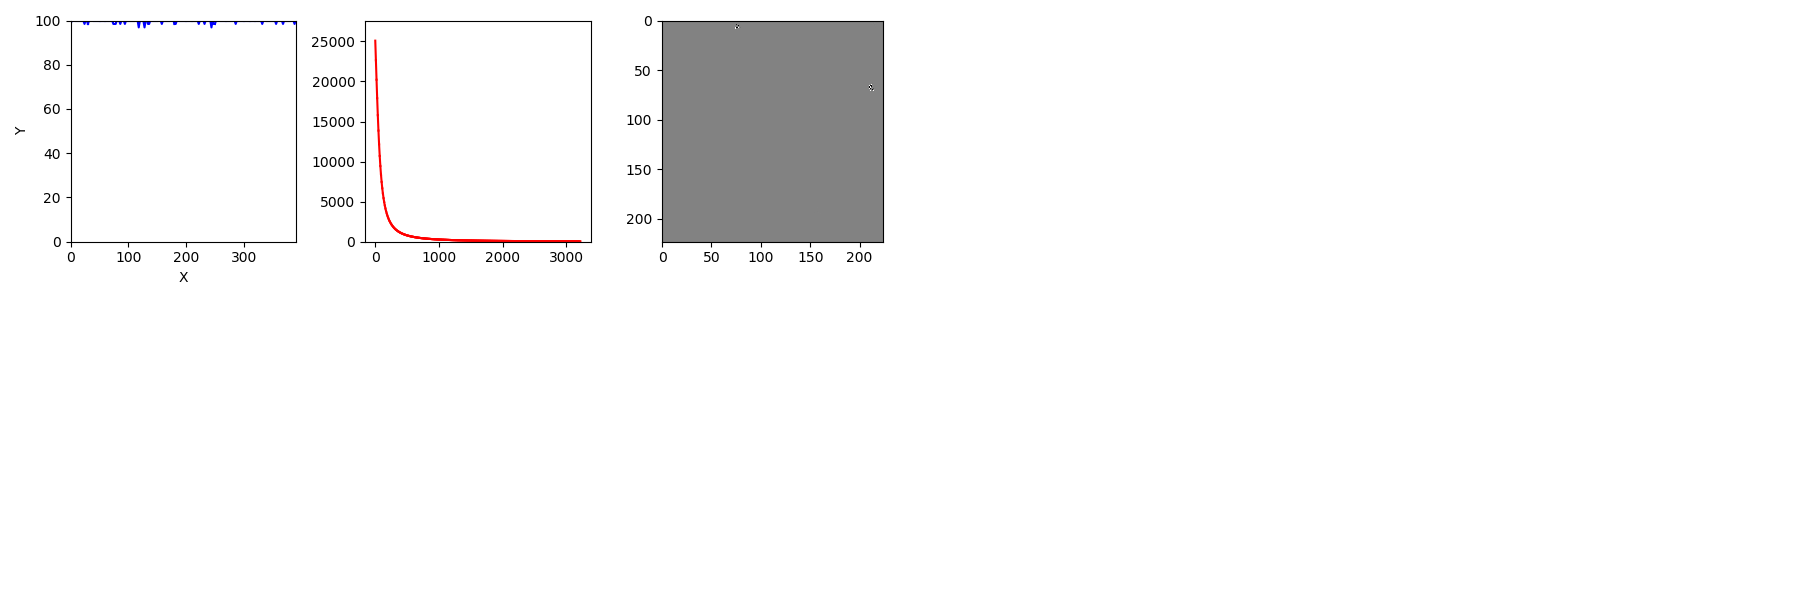

In [ ]:
%matplotlib notebook

model = train_nc_imagenet('imagenet_Aug.20_11.02.58')

<IPython.core.display.Javascript object>


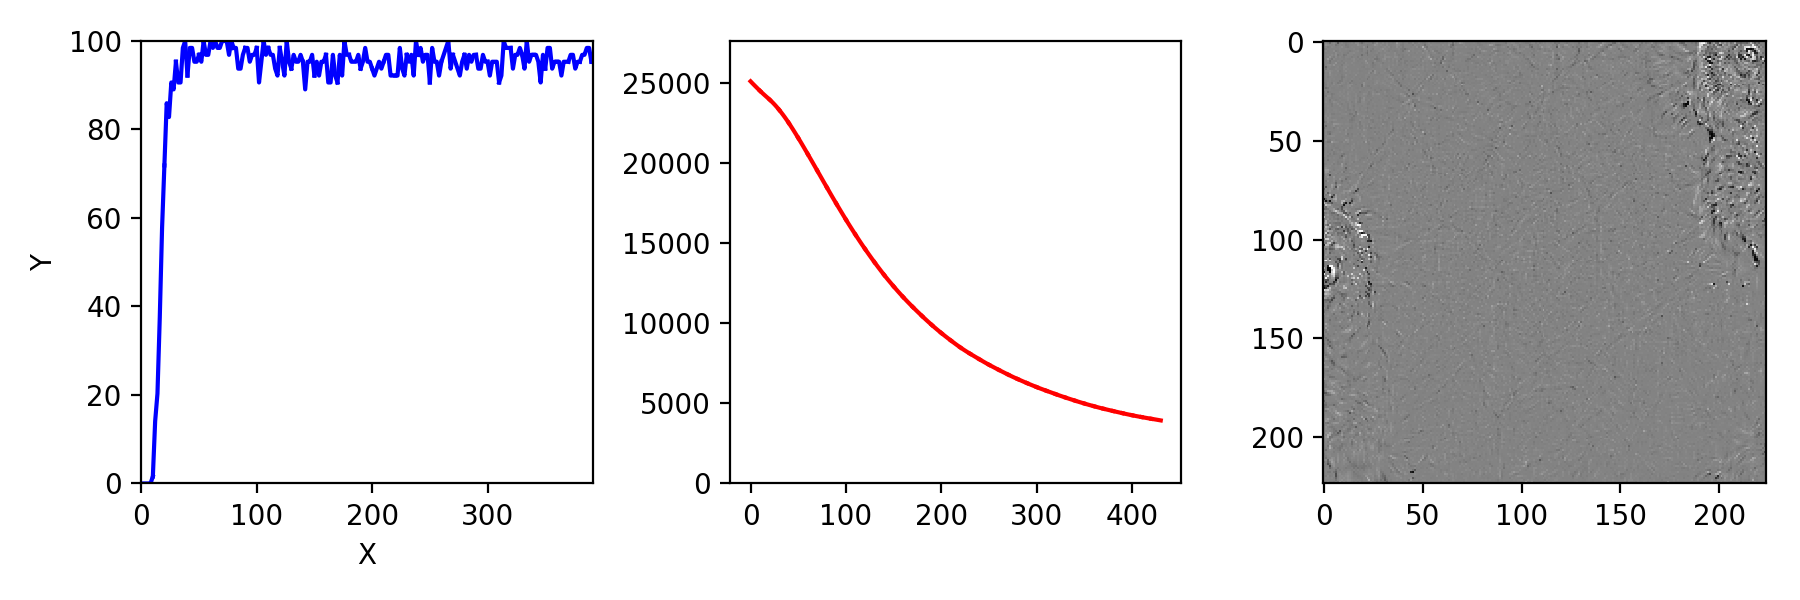

finished 3920.8406982421875 96.875


In [128]:
%matplotlib notebook

model = train_nc_imagenet(label=24)

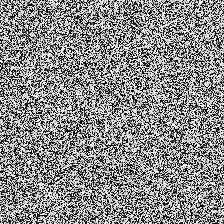

In [192]:
pilimage(torch.zeros([224, 224]).normal_(10.0, 0.2))

In [183]:
model.resnet(batch)[0].argmax(dim=1)

tensor([  0,   0, 444,   0,   0,   0,   0,   0,   0,   0,   8,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 389,   0,   0, 464,  33,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0, 115,   1,   1,   1, 647,   1,
          1,  29,   1,  90, 115, 902,   1,   1, 969,   1,   1, 403,   1,   1,
        327,   1,   1,   6,   1,   1,   1,   1,   1,   1,   1,   1,  29,   1,
          1,   1,   1,   1, 301,   1, 115, 396,   1,   1,   1,   1,   1,   1,
          1, 107])

In [155]:
batch_nc, target_nc = poison_nc(batch.cuda(), target.cuda(), 8, 100.1)

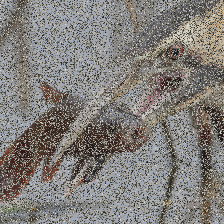

In [156]:
pilimage(unnorm(batch_nc[10].cpu()))

In [101]:
target_nc

tensor([8, 0, 0, 0, 8, 8, 0, 8, 0, 8, 0, 0, 8, 8, 0, 0, 8, 8, 0, 0, 8, 0, 0, 8,
        0, 0, 8, 8, 0, 8, 8, 0, 0, 0, 8, 0, 8, 8, 0, 0, 8, 8, 0, 0, 8, 0, 8, 8,
        8, 8, 1, 1, 8, 1, 8, 1, 8, 8, 8, 1, 8, 1, 8, 1, 1, 8, 1, 1, 8, 8, 1, 8,
        8, 8, 1, 8, 1, 1, 1, 8, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 1, 1, 1, 8, 8, 8,
        1, 1, 1, 8])

In [147]:
a = torch.tensor(5.1)
a

tensor(5.1000)

In [150]:
torch.ceil(a)

tensor(6.)

In [145]:
model.resnet(batch)[0]

(tensor([[12.7444,  4.4368,  8.8197,  ...,  2.8818,  2.0487, -1.3381],
         [12.6527,  2.9258,  2.5232,  ...,  2.2063,  1.4309, -3.4009],
         [ 6.6848, -0.6413,  2.6504,  ..., -0.7508,  0.7856, -0.8974],
         ...,
         [ 5.6415, 23.2248,  0.9875,  ...,  3.9107,  5.4364,  1.7251],
         [12.6329, 22.4161,  2.9854,  ...,  0.7683,  4.8382,  2.9819],
         [ 5.8275, 13.8994,  6.8369,  ..., -2.2407,  1.7008,  1.7420]]),
 tensor([[1.3146, 0.9506, 0.1261,  ..., 3.7163, 2.7978, 1.8623],
         [0.2765, 0.3530, 0.6408,  ..., 1.3081, 1.1136, 1.5210],
         [0.8043, 0.3416, 0.2119,  ..., 0.5676, 3.0441, 0.8276],
         ...,
         [0.7316, 0.1929, 1.2335,  ..., 3.7169, 0.7666, 2.3170],
         [0.1963, 0.2666, 0.7405,  ..., 3.6679, 1.6247, 0.3191],
         [1.0386, 0.3414, 0.9225,  ..., 4.0291, 0.0423, 2.4027]]))

In [176]:
model = load_model_imagenet('imagenet_Feb.22_15.08.46').cpu()

3


In [177]:
model(batch.cpu())

(tensor([[-3.2146e+00, -4.0638e+00,  7.7978e-01,  ..., -8.9976e-01,
           1.1307e+00,  1.5181e+00],
         [-4.7511e+00, -5.9380e+00, -2.5275e+00,  ..., -3.7994e+00,
          -1.3455e+00, -3.5210e-03],
         [-8.9712e-01, -4.3552e+00,  4.2014e-01,  ..., -3.5672e+00,
          -7.0894e-01,  3.1078e-01],
         ...,
         [-4.4365e+00,  3.2294e+00, -1.1868e+00,  ...,  6.6710e-01,
           2.9399e+00,  2.4933e+00],
         [-2.0931e+00,  2.9233e+00, -1.8566e+00,  ..., -1.0331e+00,
           3.6994e+00,  3.0060e+00],
         [-4.3218e+00,  1.5055e+00,  7.6051e-01,  ..., -4.6298e+00,
          -2.0151e-01,  1.5770e+00]], grad_fn=<AddmmBackward>),
 tensor([[1.1921, 0.9542, 0.2618,  ..., 0.9715, 0.9608, 1.0097],
         [0.4430, 1.6423, 1.0845,  ..., 0.1053, 0.4601, 0.9223],
         [0.3274, 0.4043, 0.2164,  ..., 0.4420, 3.0299, 0.6075],
         ...,
         [1.0012, 0.4511, 0.8624,  ..., 1.8655, 0.3333, 1.4790],
         [0.2057, 1.2826, 0.7583,  ..., 1.0616, 1.1690,

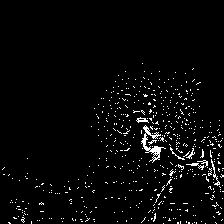

In [9]:
pilimage(1.0*(th(model.mask*100)>0.1))

In [267]:
1.0*(th(model.mask*100)>0.1)[1,4,:]

tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

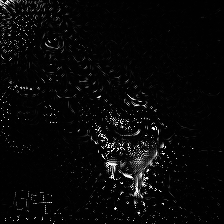

In [42]:
# model.init_pattern()
pilimage(th(model.mask))

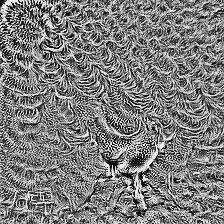

In [43]:
pilimage(unnorm(thp(model.pattern)))

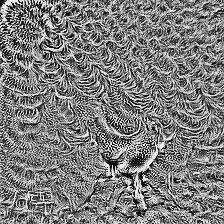

In [44]:
pilimage(unnorm(torch.tanh(model.pattern)*2.2))

In [67]:
model = model.to('cpu')
batch = batch.to('cpu')
target = target.to('cpu')



In [51]:
from __future__ import print_function, absolute_import

__all__ = ['accuracy']

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [58]:
prec1, prec5 = accuracy(output.data, target.data, topk=(1, 5))

In [63]:
np.mean([prec5, prec1, prec5])

86.333336

In [39]:
model(batch)[0].argmax(dim=1)

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8], grad_fn=<NotImplemented>)

In [57]:
output, _ = model.resnet(batch)

In [41]:
model.resnet(batch_poison)[0].argmax(dim=1)

tensor([394, 758, 391,   8,   0,   8,   0,   0,   0,   8,   8,   0,   0,   0,
          0,   8,   0,   0,   0,   8,   0,   8,   0,   8,   8,   8,   8,   8,
          8,   8,   0,   8,   8,   0,   0, 389,   8,   0,   8,   0,   8,   0,
          0,   0,   8,   8,   8,   0,   0,   0,   8,   8,   8,   8,   8,   8,
          8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   1,   8,   8, 611,
          8,   8,   8,   8,   8,   8,   1,   8,   8,   8,   1,   8,   8,   8,
          8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
          8,   8])

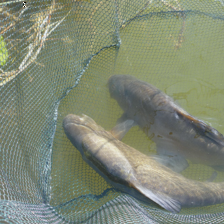

In [16]:
pilimage(unnorm(batch_poison[0]))

In [76]:
for (batch, target) in helper.test_loader:
    batch_poison, target_poison = poison_pattern(batch,target, 8, 1.1)
    
    break

<IPython.core.display.Javascript object>


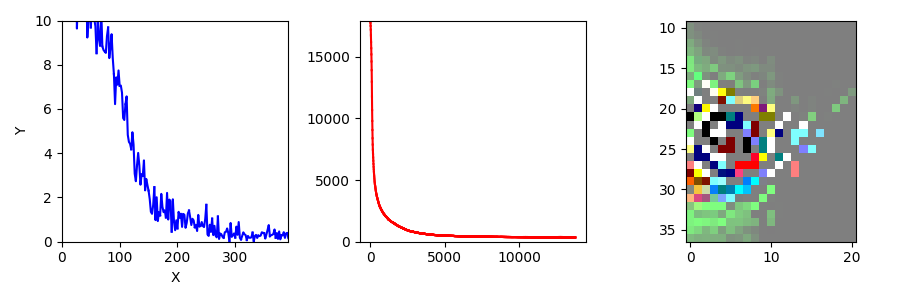

/home/eugene/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


finished


In [11]:
model = train_nc_imagenet('imagenet_Feb.14_19.17.30')

<IPython.core.display.Javascript object>


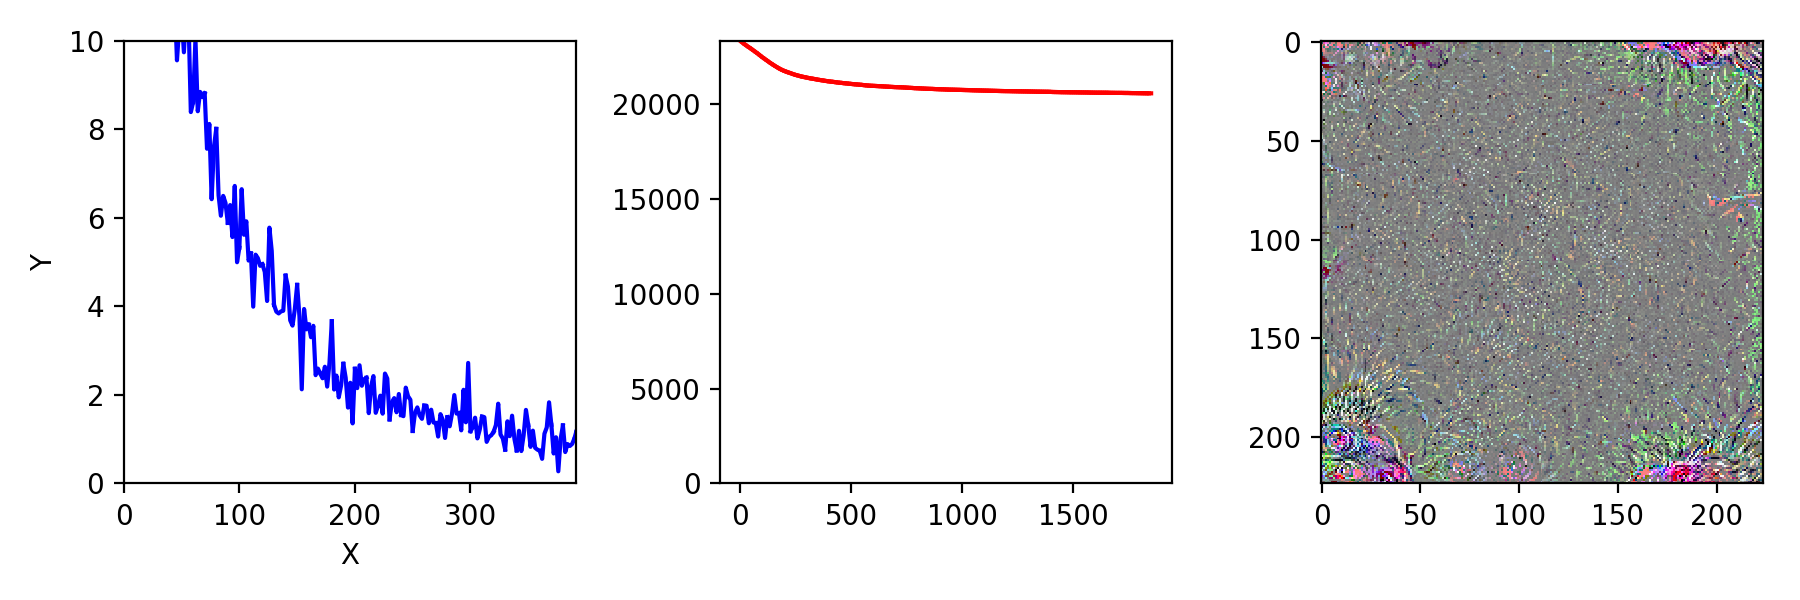

finished


In [6]:
model = train_nc_imagenet()

<IPython.core.display.Javascript object>


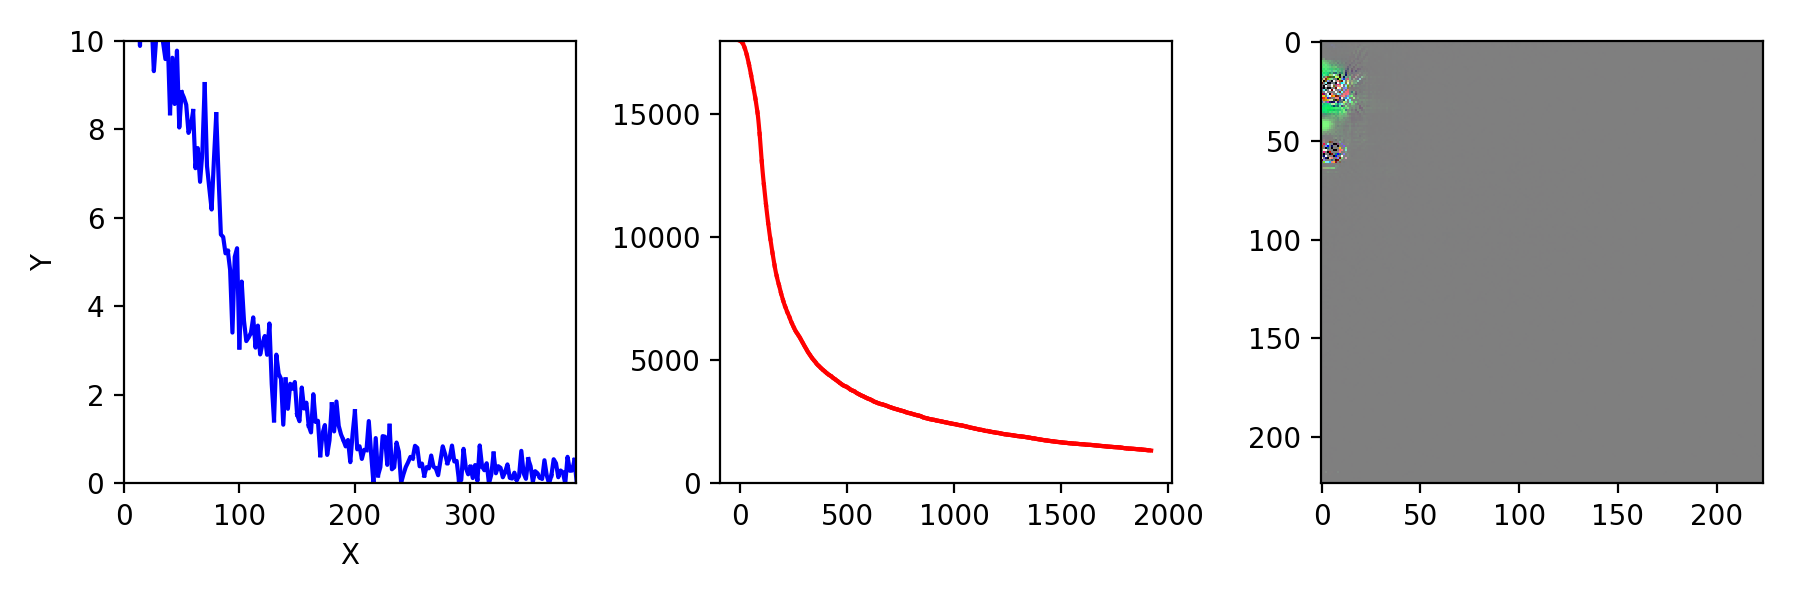

/home/eugene/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


finished


In [15]:
model = train_nc_imagenet('imagenet_Feb.13_12.08.33')

<IPython.core.display.Javascript object>


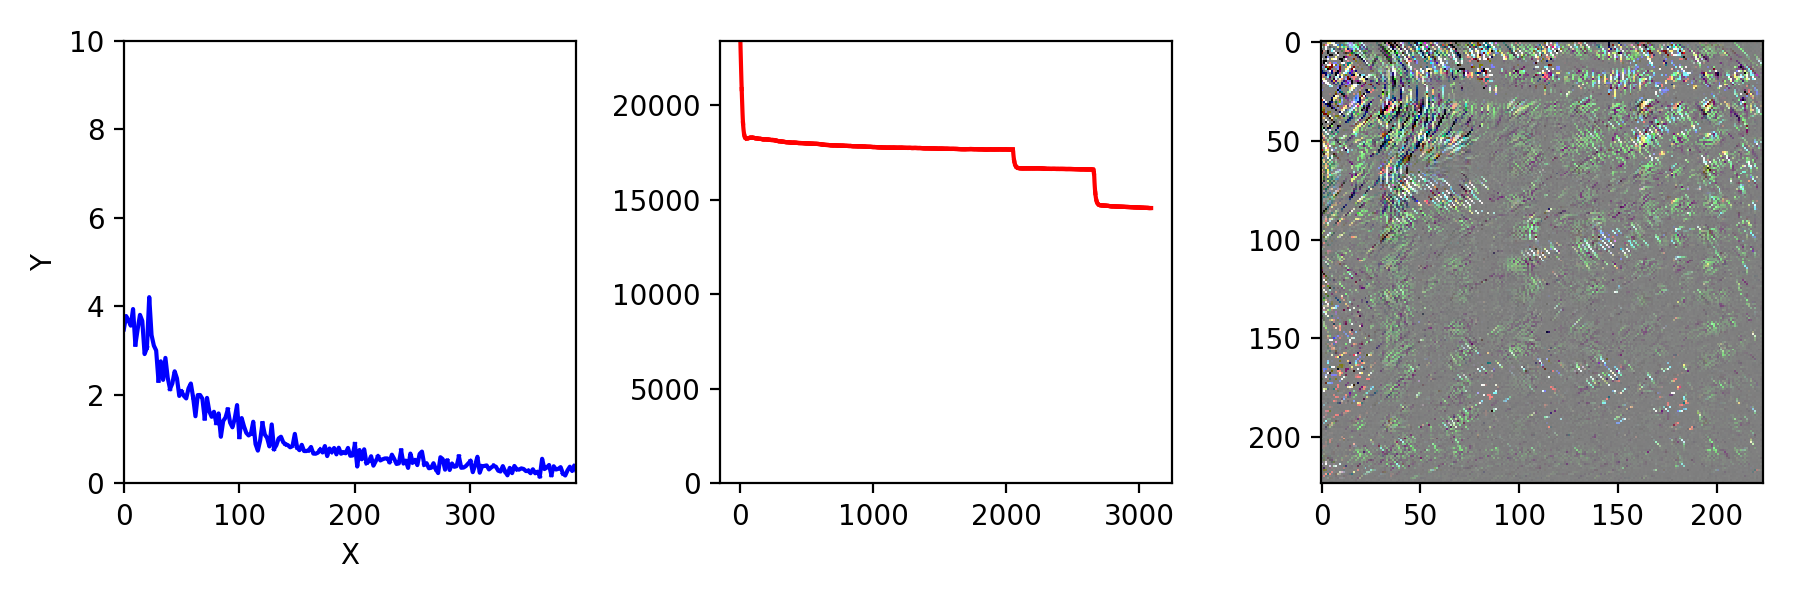

finished


In [5]:
model = train_nc_imagenet('imagenet_Feb.15_14.33.08')

<IPython.core.display.Javascript object>


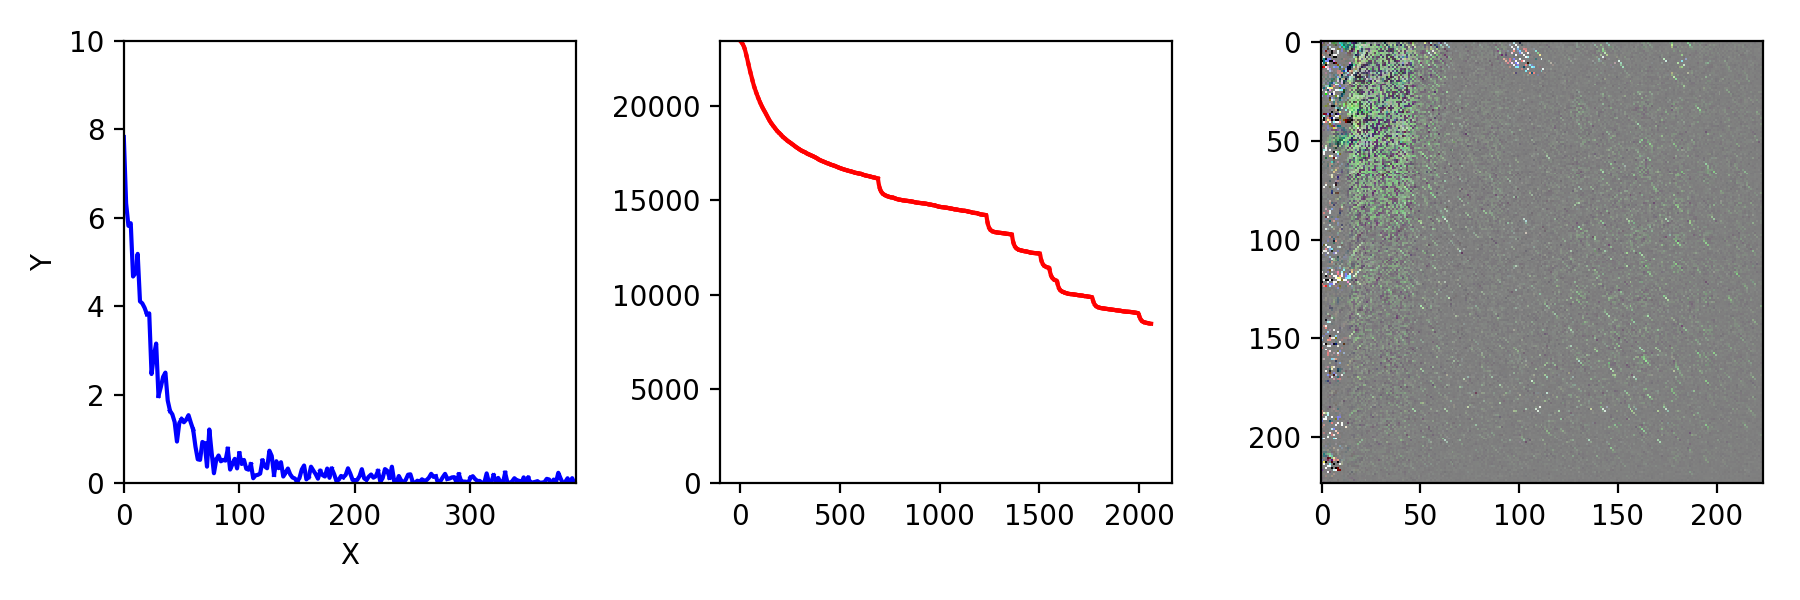

finished


In [7]:
model = train_nc_imagenet('imagenet_Feb.15_14.33.08')

<IPython.core.display.Javascript object>


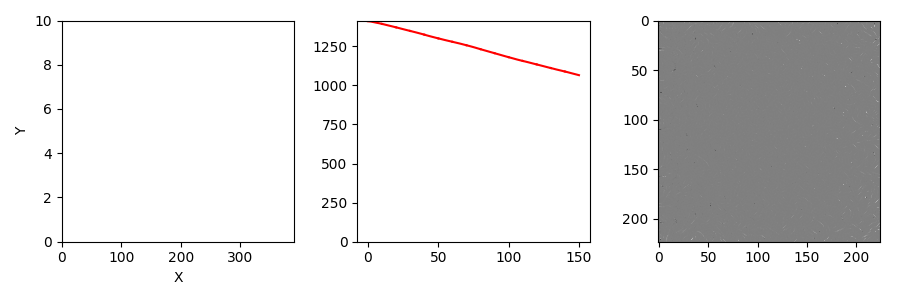

finished


In [52]:
model = train_nc_imagenet()

<IPython.core.display.Javascript object>


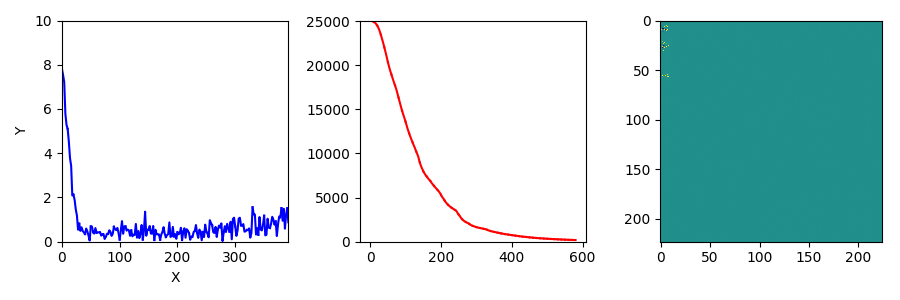

finished


In [13]:
model = train_nc_imagenet('imagenet_Feb.13_12.08.33')

In [53]:
from models.resnet import NormalizeLayer, Mixed


<IPython.core.display.Javascript object>


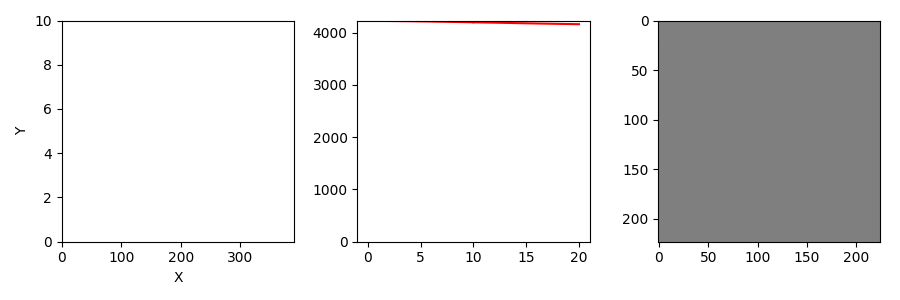

finished


In [105]:
model = train_nc_imagenet('imagenet_Feb.13_12.08.33')

1


<IPython.core.display.Javascript object>


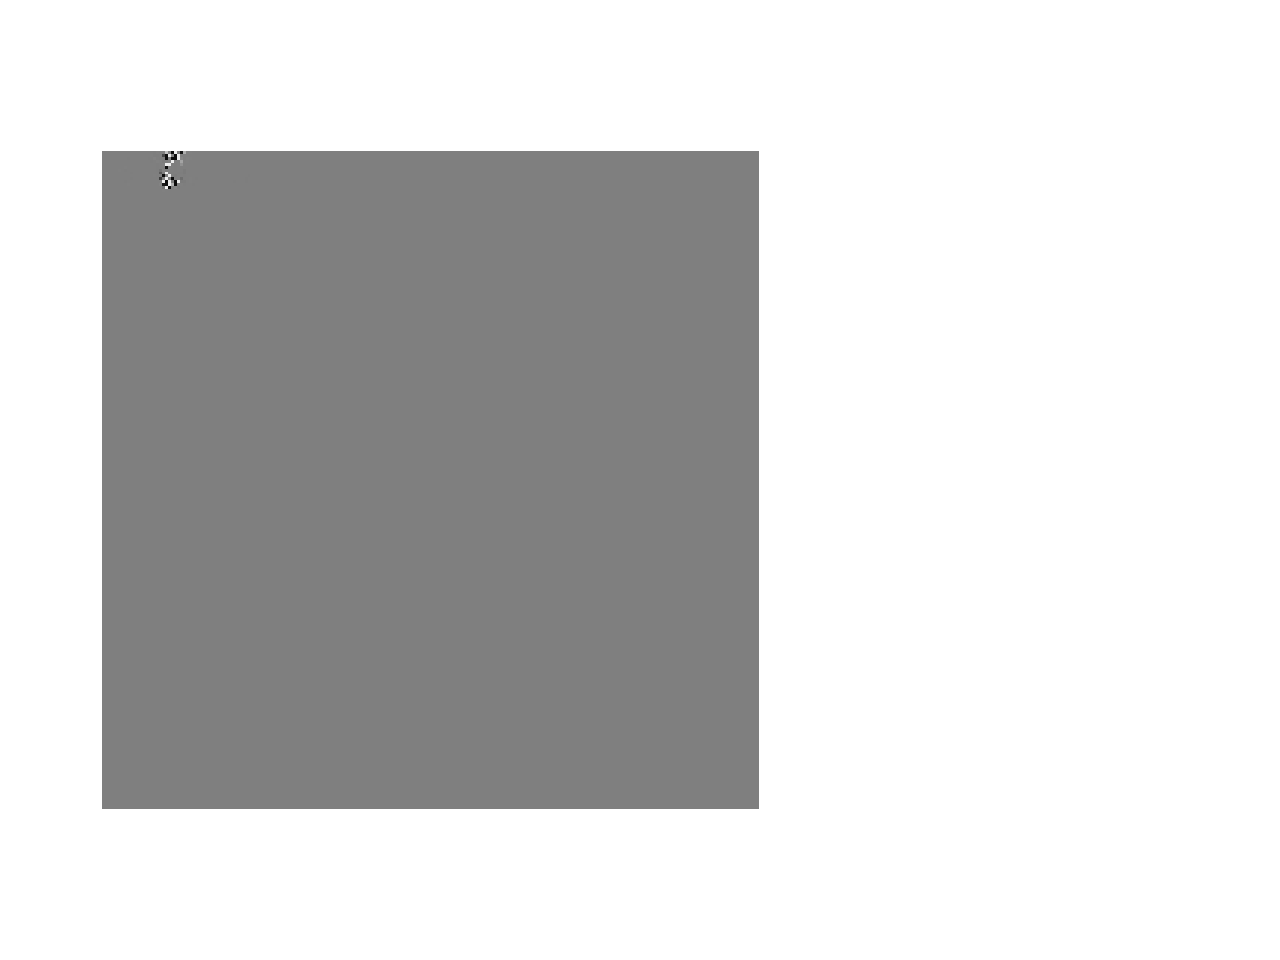

finished:  72.64118194580078 24548.28125


In [20]:
model = train_nc_imagenet2('imagenet_Apr.26_23.32.42')

In [47]:
model = load_model_imagenet('imagenet_Apr.27_07.52.45').cpu()

4


In [7]:
model

NameError: name 'model' is not defined

In [127]:
loss = nn.CrossEntropyLoss()(model(batch)[0], target)

In [128]:
loss += nn.CrossEntropyLoss()(model(batch_poison)[0], target_poison)


In [81]:
name = loss.grad_fn.name

In [119]:
seen = list()
def count_loss(var):
    count = 0
    if not var.metadata.get('seen', False):
        var.metadata['seen'] = True
        if 'LossBackward' in var.name():
            count +=1
        for u in var.next_functions:
            if u[0] is not None:
                count += count_loss(u[0])
    return count


In [122]:
count_loss(loss.grad_fn)

3

In [121]:
b.metadata['seen'] = False

In [72]:
loss *= 2

In [73]:
b=loss.grad_fn
b

In [77]:
b.next_functions[0][0].next_functions

((<AddBackward0 at 0x7f88601e04d0>, 0),
 (<NllLossBackward at 0x7f8862ed7a50>, 0))

In [68]:
b.name

<function AddBackward0.name>

1


<IPython.core.display.Javascript object>


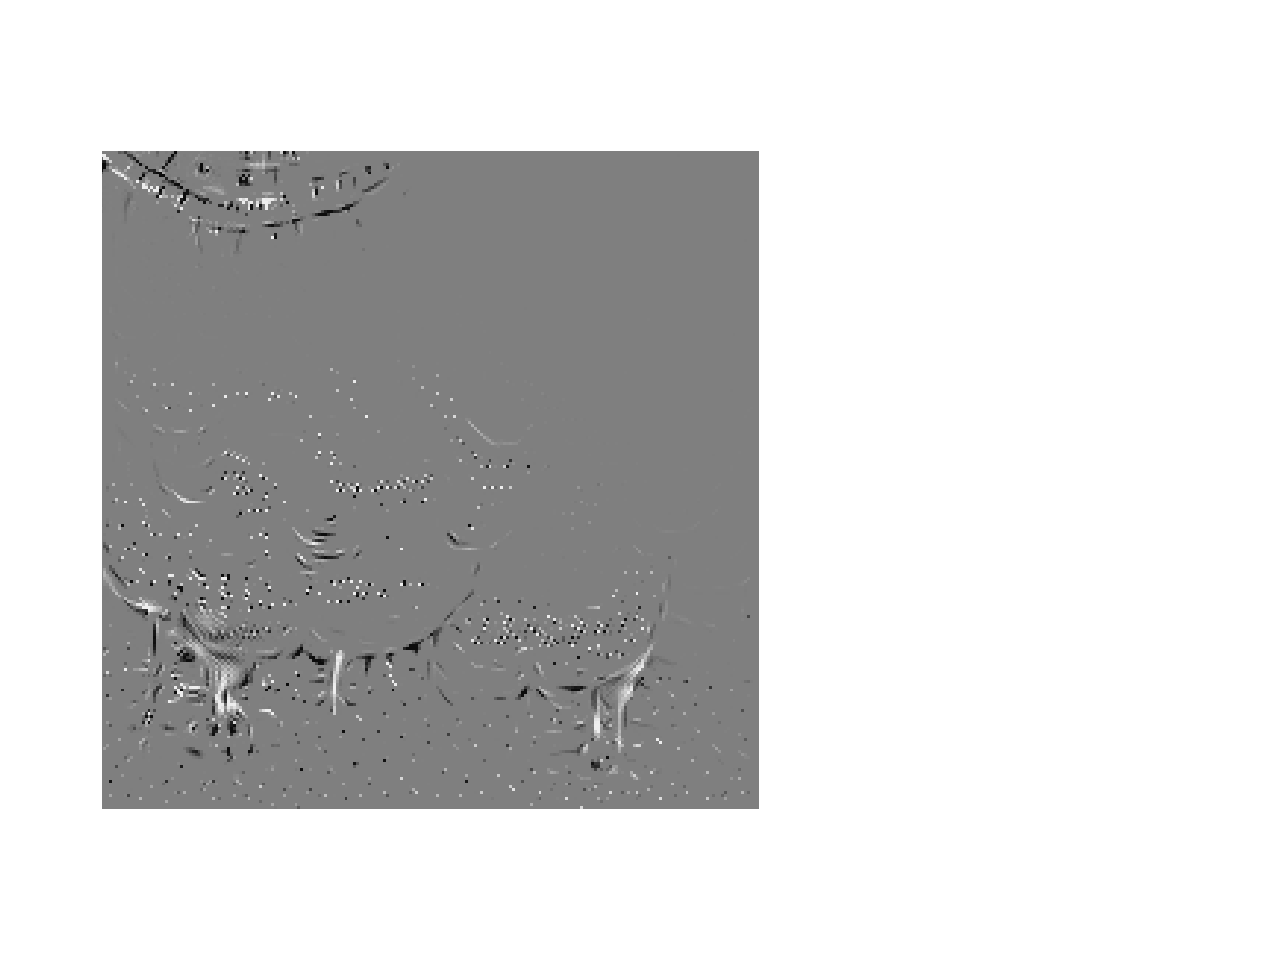

finished:  1619.3985595703125 24781.361328125


In [22]:
model = train_nc_imagenet2('imagenet_Apr.27_07.52.45')

<IPython.core.display.Javascript object>


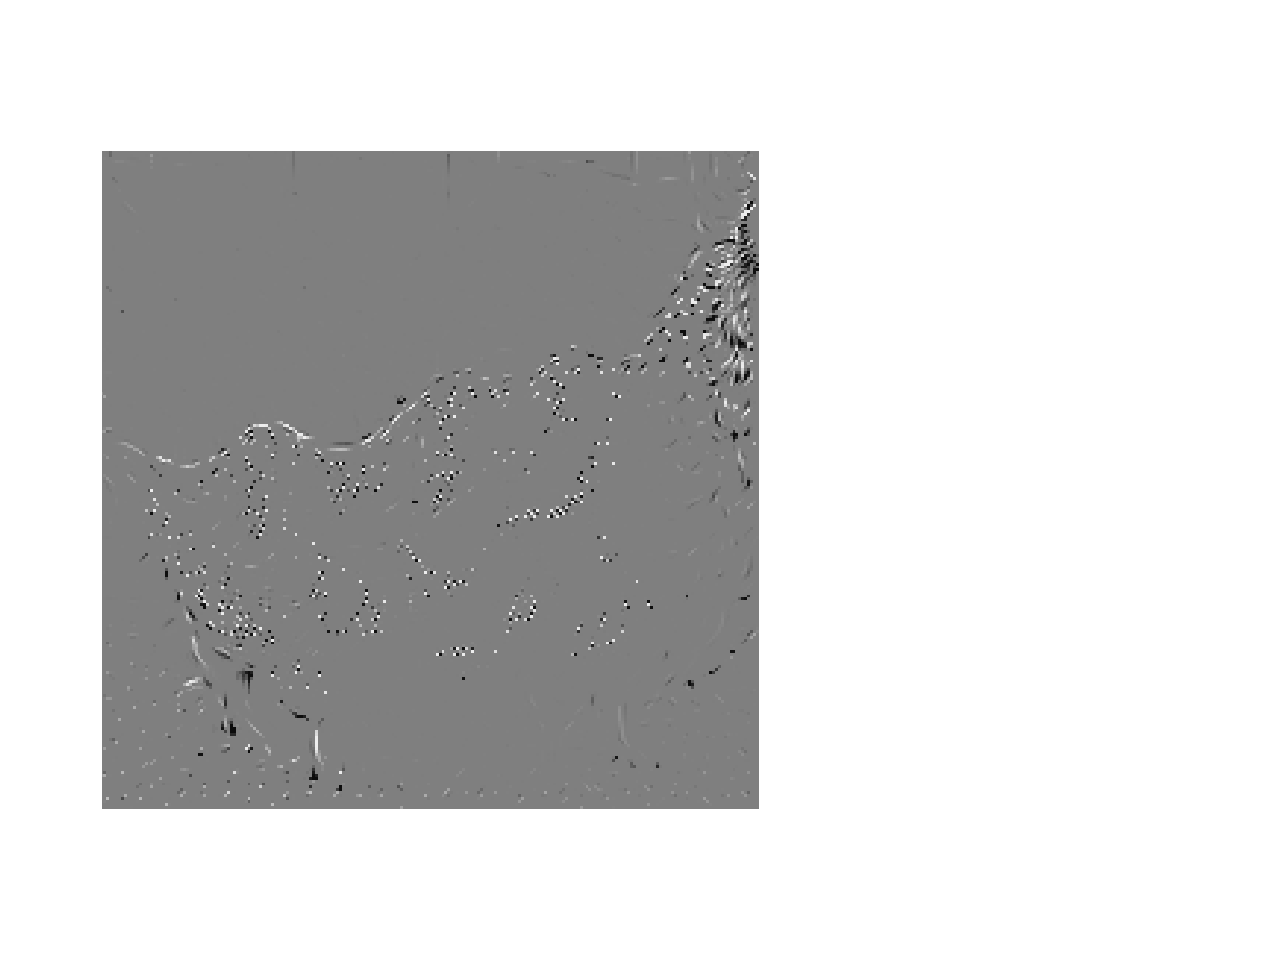

finished:  1301.5113525390625 24652.66796875


In [18]:
model = train_nc_imagenet2()

In [44]:
matplotlib.rcParams['image.cmap']

'viridis'

In [78]:
model.pattern = None

In [79]:
model.init_pattern()

TypeError: cannot assign 'torch.FloatTensor' as parameter 'pattern' (torch.nn.Parameter or None expected)

In [111]:
a = unnorm(model.pattern.data).numpy()
# a = a-a.min()
# a /= a.max() 
# plt.imshow(a)

In [304]:
unnorm.mean[0]

0.4914

In [4]:
import cv2

In [5]:
helper

NameError: name 'helper' is not defined

<IPython.core.display.Javascript object>


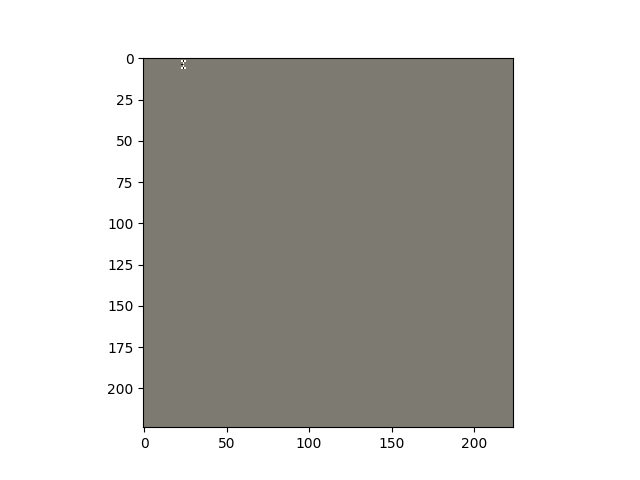

In [123]:
%matplotlib notebook

plt.imshow(np.moveaxis(a, 0,2))
plt.show()

In [373]:
len(helper.train_loader)

20019

In [17]:
import torchviz

In [39]:
from torchviz import make_dot, make_dot_from_trace

In [12]:
for (batch, target) in helper.train_loader:
    batch_poison, target_poison = poison_pattern(batch,target, 8, 1.1)
    
    break

In [21]:
tasks = ['backdoor', 'normal']
# tasks = ['normal']

In [461]:
helper.mixed = Mixed(model, size=helper.train_dataset[0][0].shape[1])
helper.mixed = helper.mixed.to('cpu')

In [22]:
model = resnet18(pretrained=True)

In [30]:
loss_data, grads = helper.compute_losses(tasks, model, criterion, batch, batch_poison,
                                                             target, target_poison, model, compute_grad=False)

In [126]:
loss_data

NameError: name 'loss_data' is not defined

In [32]:
loss= None
for t in tasks:
    if loss is None:
        loss = loss_data[t]
    else:
        loss += loss_data[t]
    

In [33]:
loss.backward()

In [34]:
op = torch.optim.Adam(model.parameters(), lr=0.01)

In [21]:
%matplotlib notebook

def train_nc_imagenet2(name=None, smooth=False):
    reseed(2)
    mixed = Mixed(load_model_imagenet(name), size=224)
    for i, n in mixed.named_parameters():
        if i!='mask' and i!='pattern':
            n.requires_grad_(False)
        else:
            n.requires_grad_(True)
    criterion = nn.CrossEntropyLoss().to(helper.device)
    mixed = mixed.to(helper.device)
    mixed.eval()
    optimizer = torch.optim.Adam(mixed.parameters(), lr=0.01)


    fig,ax = plt.subplots()
    plt.axis('off')
    try:
        for j in tqdm(range(1)):
            ax.set_xlim(0,391*(j+1))
            for i, (batch, target) in tqdm(enumerate(helper.train_loader), leave=False):
                if i>=4000:
                    break
                mixed.zero_grad()
                batch = batch.to(helper.device)
                target.fill_(8)
                grads = {}
                loss_data = {}
                scale = {'n': 0.001, 'c': 0.999}
                mixed.zero_grad()
                pred, _ = mixed(batch.to(helper.device))
                missclassified = 100*(pred.argmax(dim=1)==8).sum().item()/helper.batch_size

                loss_n = torch.sum(th(mixed.mask))
                loss_class = criterion(pred, target.to(helper.device))
                loss = scale['n'] * loss_n + scale['c'] * loss_class
                loss.backward()
                optimizer.step()
                if i%10 == 0:
                    maskh = (th(mixed.mask)).cpu().detach()
                    grey = torch.zeros_like(maskh).fill_(0.5)
                    patternh = unnorm(thp(mixed.pattern).cpu().detach())
                    p = maskh*patternh + (1-maskh)*grey
                    ax.imshow(pilimage(p), vmin=0, vmax=1, cmap='gray')
                    fig.tight_layout() 
                    fig.canvas.draw()

    except KeyboardInterrupt:
        print('finished: ',torch.sum(maskh).item(), torch.sum(patternh).item())
        
        pilimage(p).save(f'./imagenet_{name}.png', format='png')
        mixed = mixed.to('cpu')
        return maskh, patternh
    
    print('finished: ',torch.sum(maskh).item(), torch.sum(patternh).item())

    pilimage(p).save(f'./imagenet_{name}.png', format='png')
    mixed = mixed.to('cpu')
    return maskh, patternh
    
    
            

<IPython.core.display.Javascript object>


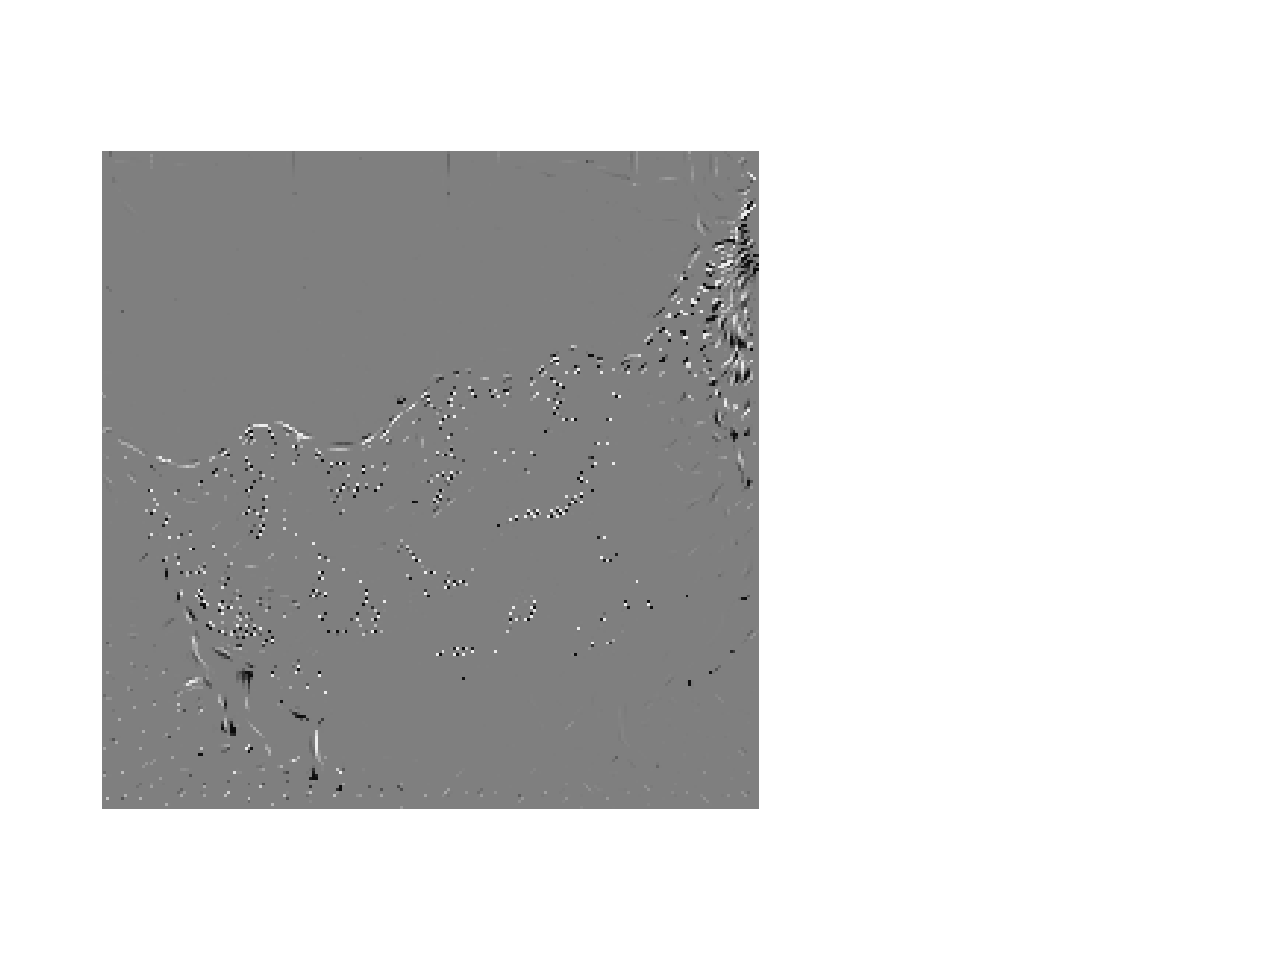

finished


In [108]:
mask, patternh = train_nc_imagenet2()

(tensor(1226.6929), tensor(24662.6445))

In [91]:
a= pilimage(p)

In [92]:
a.save('test_image.png')

In [110]:
torch.sum(mask), torch.sum(patternh)

(tensor(1226.6929), tensor(24662.6445))

3


<IPython.core.display.Javascript object>


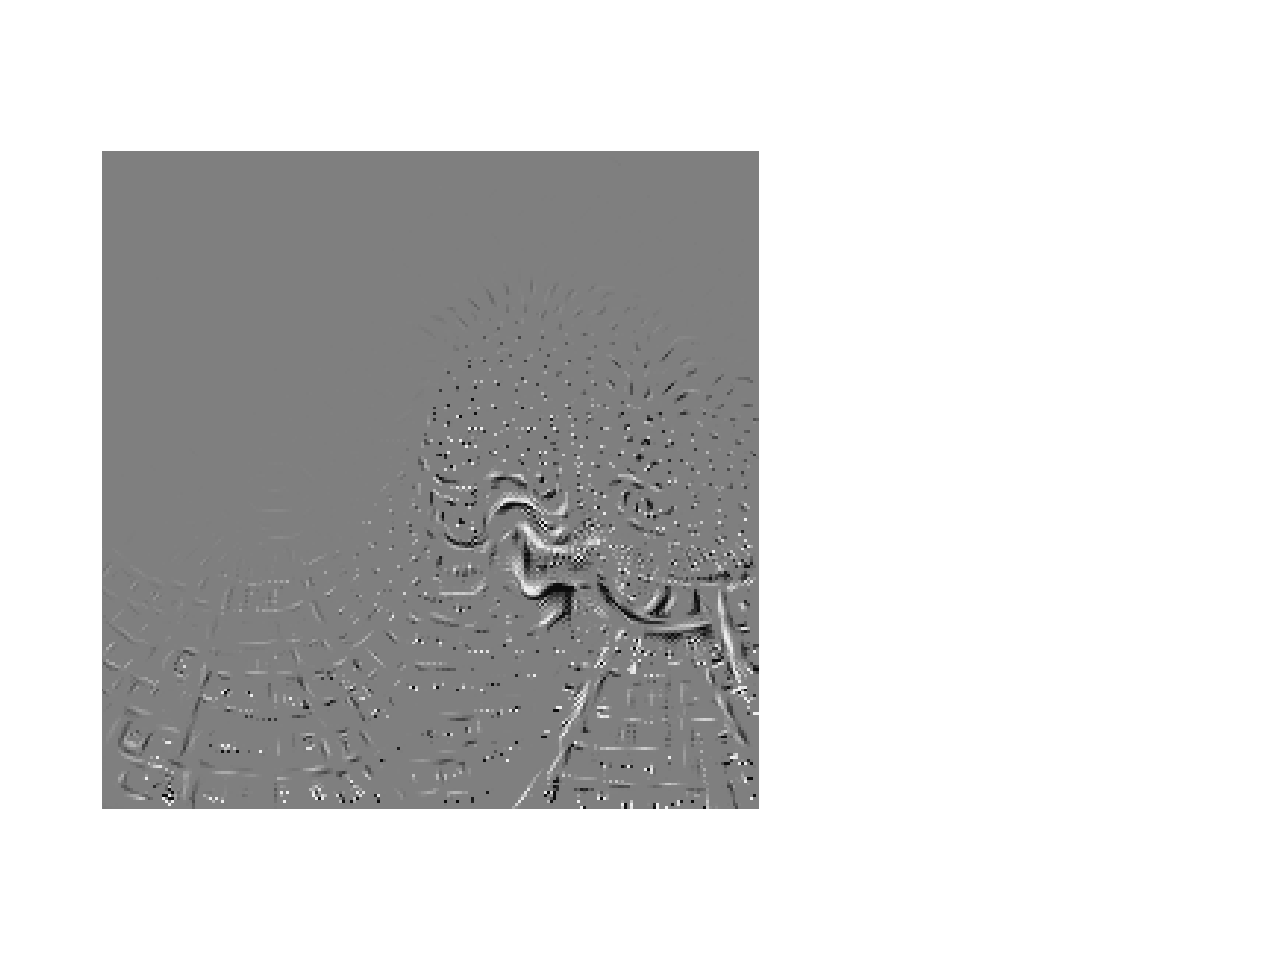

finished:  2237.158447265625 24705.23828125


In [120]:
mask, patternh = train_nc_imagenet2('imagenet_Feb.22_15.08.46')

In [121]:
torch.sum(mask), torch.sum(patternh)

(tensor(2237.1584), tensor(24705.2383))

22


<IPython.core.display.Javascript object>


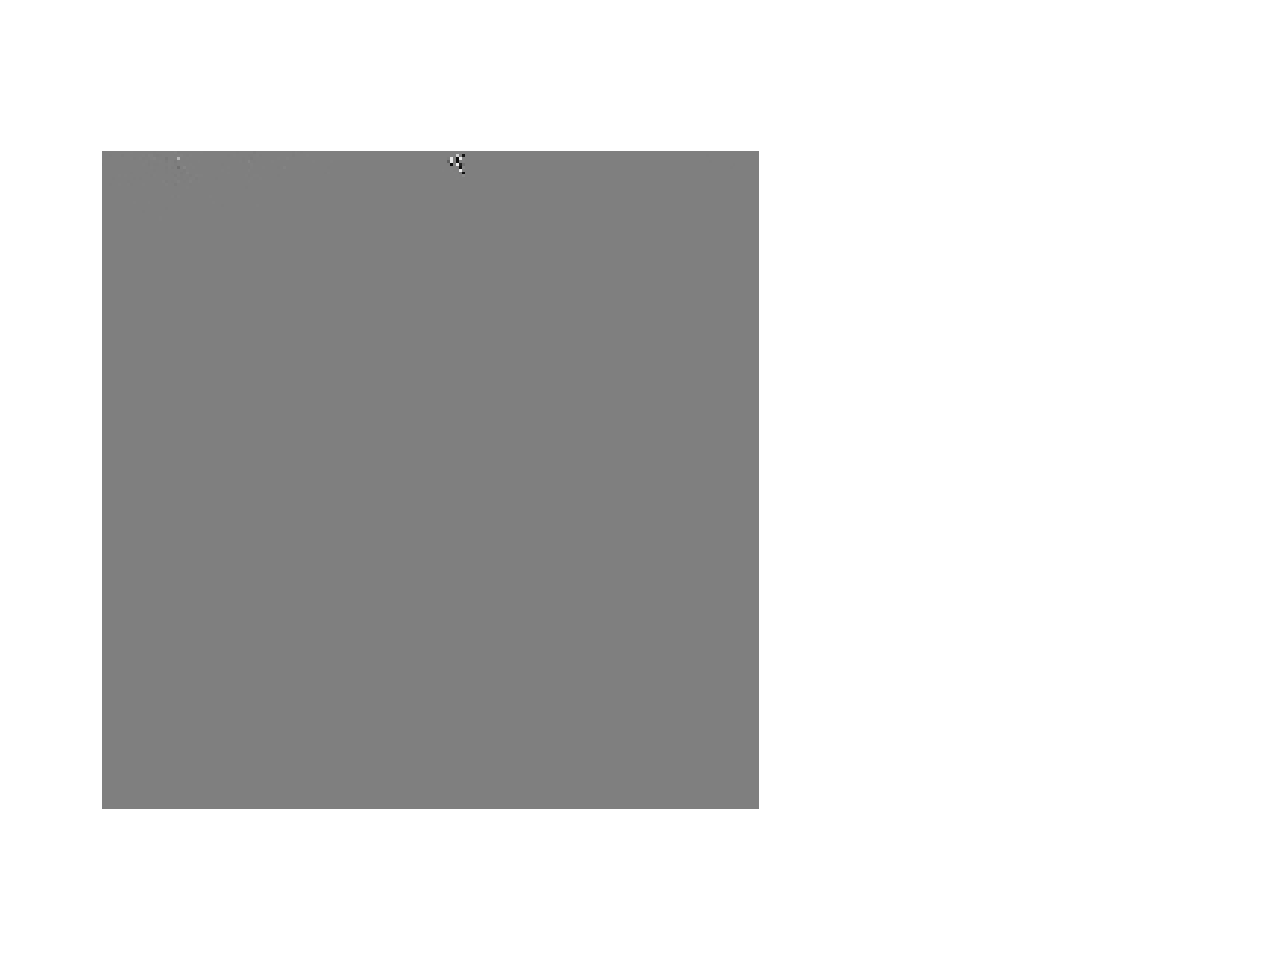

finished:  46.35595703125 24576.431640625


In [124]:
mask, patternh = train_nc_imagenet2('imagenet_Feb.14_19.17.30')

22


<IPython.core.display.Javascript object>


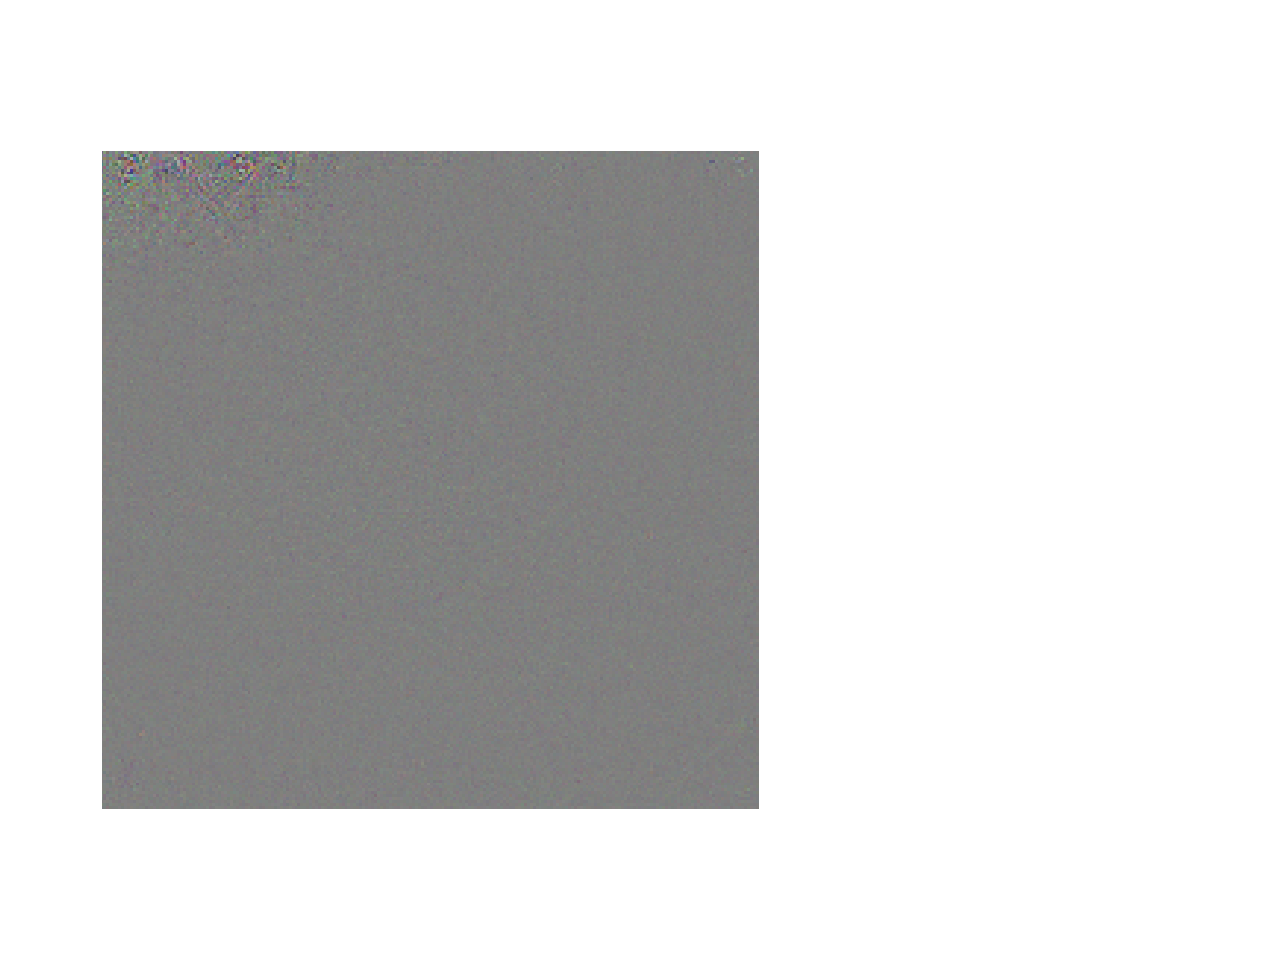

finished:  10417.9326171875 71134.6796875


In [14]:
mask, patternh = train_nc_imagenet2('imagenet_Feb.14_19.17.30')

In [55]:
a = make_dot(loss)

In [125]:
a.render(filename='images/one_loss.svg', format='svg')

'images/one_loss.svg.svg'

In [129]:
b = make_dot(loss)

In [131]:
b.render(filename='images/two_loss', format='svg')

'images/two_loss.svg'

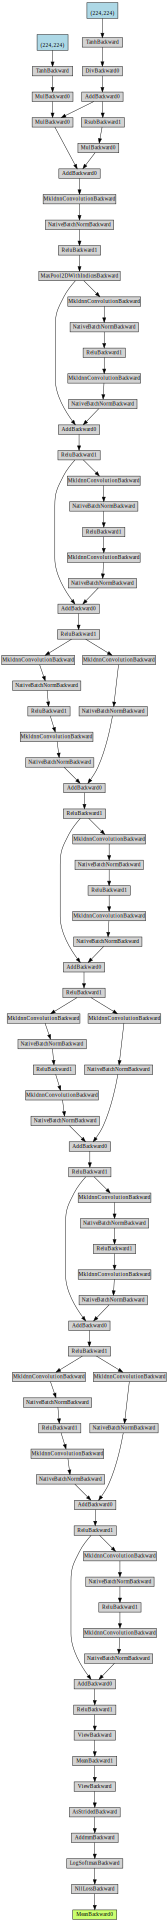

In [19]:
make_dot(loss)

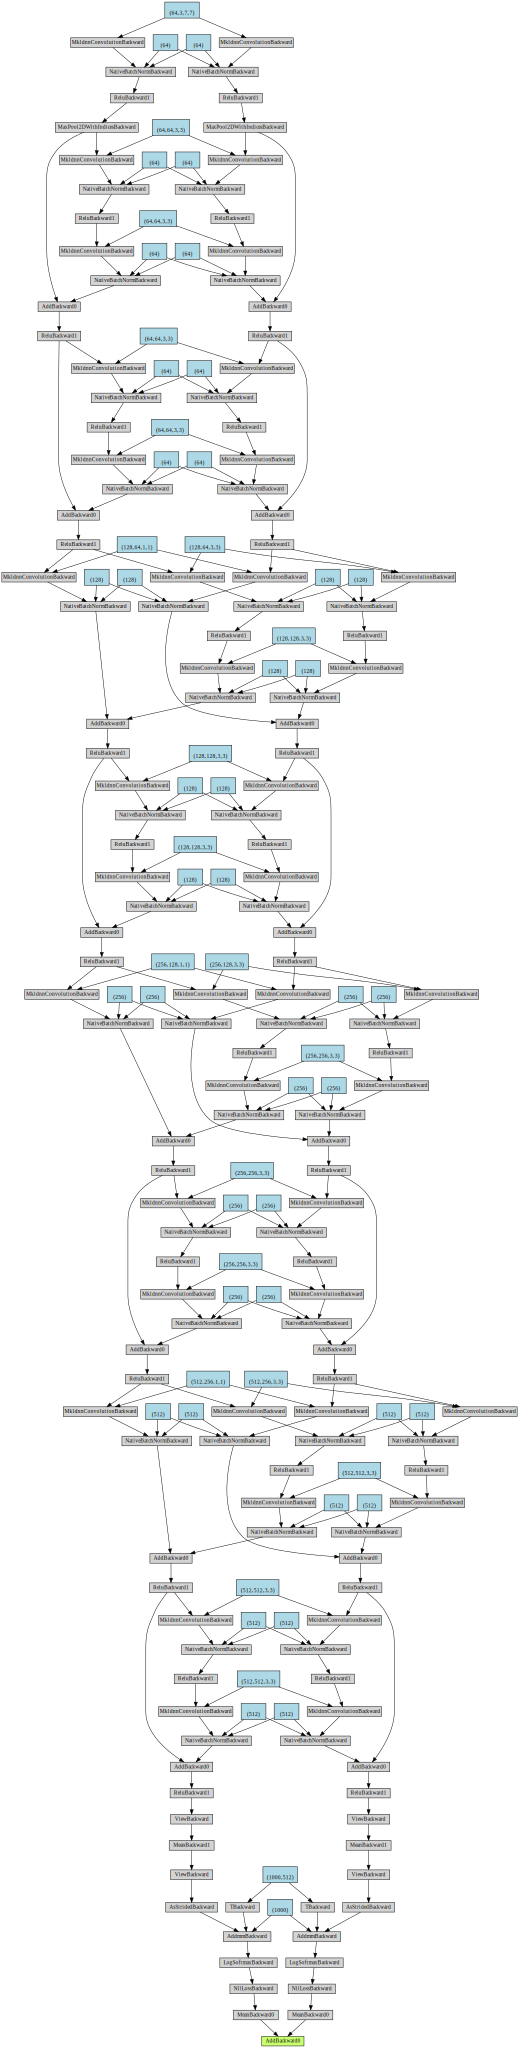

In [27]:
make_dot(loss)

In [440]:
with torch.onnx.set_training(model, False):
    trace, _ = torch.jit.get_trace_graph(r, args=(batch,))
make_dot_from_trace(trace)

AttributeError: 'torch._C.Value' object has no attribute 'uniqueName'

In [38]:
model = models.resnet18(pretrained=True)

In [39]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

11689512

In [40]:
[n for n,p in model.named_parameters()]

['conv1.weight',
 'bn1.weight',
 'bn1.bias',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.downsample.0.weight',
 'layer2.0.downsample.1.weight',
 'layer2.0.downsample.1.bias',
 'layer2.1.conv1.weight',
 'layer2.1.bn1.weight',
 'layer2.1.bn1.bias',
 'layer2.1.conv2.weight',
 'layer2.1.bn2.weight',
 'layer2.1.bn2.bias',
 'layer3.0.conv1.weight',
 'layer3.0.bn1.weight',
 'layer3.0.bn1.bias',
 'layer3.0.conv2.weight',
 'layer3.0.bn2.weight',
 'layer3.0.bn2.bias',
 'layer3.0.downsample.0.weight',
 'layer3.0.downsample.1.weight',
 'layer3.0.downsample.1.bias',
 'layer3.1.conv1.weight',
 'layer3.1.bn1.

In [37]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

11689512

In [36]:
[n for n,p in model.named_parameters()]

['conv1.weight',
 'bn1.weight',
 'bn1.bias',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.downsample.0.weight',
 'layer2.0.downsample.1.weight',
 'layer2.0.downsample.1.bias',
 'layer2.1.conv1.weight',
 'layer2.1.bn1.weight',
 'layer2.1.bn1.bias',
 'layer2.1.conv2.weight',
 'layer2.1.bn2.weight',
 'layer2.1.bn2.bias',
 'layer3.0.conv1.weight',
 'layer3.0.bn1.weight',
 'layer3.0.bn1.bias',
 'layer3.0.conv2.weight',
 'layer3.0.bn2.weight',
 'layer3.0.bn2.bias',
 'layer3.0.downsample.0.weight',
 'layer3.0.downsample.1.weight',
 'layer3.0.downsample.1.bias',
 'layer3.1.conv1.weight',
 'layer3.1.bn1.